<a href="https://colab.research.google.com/github/VLCHS/FCNN-for-p_pi0/blob/FCNN/Training_FCNN_p_pi0%26results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Getting Started

In [ ]:
!pip install --q wandb
!pip install --q wandb[media]
!pip install --q torch==2.5.1
!pip install --q lightning==2.4.0
!pip install --q featuretools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.3/33.3 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.9/587.9 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.2/215.2 kB 12.1 MB/s eta 0:00:00


In [ ]:
# necessary code, if wandb doesn't want to login for no reason
import os
os.environ['WANDB_INIT_TIMEOUT'] = '300'
os.environ['WANDB_HTTP_TIMEOUT'] = '300'
os.environ["WANDB__SERVICE_WAIT"] = "300"
os.environ['WANDB_DEBUG'] = 'true'
os.environ['WANDB_CORE_DEBUG'] = 'true'

In [ ]:
import os
import sys

import tqdm
import math
import wandb
wandb.require("legacy-service")

import torch
import pylab
import random
import logging
import torchmetrics

import numpy as np
import pandas as pd
import torch.nn as nn
import lightning.pytorch as pl
import matplotlib.pyplot as plt
import featuretools as ft

from scipy import spatial
from random import randint
from scipy.stats import chisquare, kstest
from scipy.optimize import curve_fit
from torchmetrics import MeanAbsoluteError
from torchmetrics import MeanSquaredError
from torchmetrics import R2Score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from torch.utils.data import Dataset, DataLoader
from lightning.pytorch.loggers import WandbLogger
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import Callback, LearningRateMonitor, ModelCheckpoint

def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    pl.seed_everything(seed)

set_random_seed(42)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


In [ ]:
device = "gpu" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving clasdb_pi_0_p.txt to clasdb_pi_0_p.txt


In [ ]:
# Load the data Ebeam = [1.64 2.44 5.75 2.04]
df = pd.read_csv('/content/clasdb_pi_0_p.txt', delimiter='\t', header=None)
df.columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi', 'dsigma_dOmega', 'error', 'id']
df['phi'] = df.phi.apply(lambda x: math.radians(x))
df['cos_phi'] = df['phi'].apply(lambda x: math.cos(x))
df['sin_phi'] = df['phi'].apply(lambda x: math.sin(x))
df['Ebeam'] = df['Ebeam'].round(decimals=2)
df = df.replace({"Ebeam": {2.45: 2.44, 1.65: 1.64}})
df = df[df['dsigma_dOmega'] <= df["dsigma_dOmega"].quantile(0.97)]
df = df[df['error'] <= df["error"].quantile(0.98)]
df = df.drop(df[df['dsigma_dOmega'] == 0].index)
df = df.drop('id', axis=1)
df = df.reset_index(drop=True)
df = df.iloc[df[['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']].drop_duplicates().index]
df = df.reset_index(drop=True)
df

,Ebeam,W,Q2,cos_theta,phi,dsigma_dOmega,error,cos_phi,sin_phi
0,1.64,1.1000,0.40,-0.9,0.261799,0.912000,0.982353,0.965926,0.258819
1,1.64,1.1000,0.40,-0.9,0.785398,0.175000,0.356108,0.707107,0.707107
2,1.64,1.1000,0.40,-0.9,1.308997,1.650000,2.769879,0.258819,0.965926
3,1.64,1.1000,0.40,-0.9,1.832596,0.560000,0.979330,-0.258819,0.965926
4,1.64,1.1000,0.40,-0.9,2.356194,1.130000,0.909689,-0.707107,0.707107
...,...,...,...,...,...,...,...,...,...
72238,2.04,1.7875,0.65,0.9,4.581489,0.485355,0.093559,-0.130526,-0.991445
72239,2.04,1.7875,0.65,0.9,4.843289,0.528385,0.083915,0.130526,-0.991445
72240,2.04,1.7875,0.65,0.9,5.105088,0.497479,0.107885,0.382683,-0.923880
72241,2.04,1.7875,0.65,0.9,5.366887,2.774690,2.426200,0.608761,-0.793353


Text(0, 0.5, 'Q^2, GeV^2')

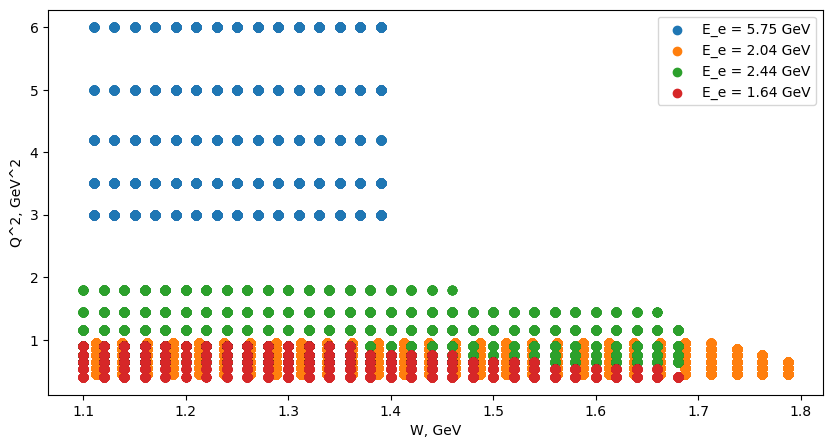

In [ ]:
plt.rcParams["figure.figsize"] = (10,5)
plt.scatter(df[df.Ebeam==5.75].W, df[df.Ebeam==5.75].Q2, label='E_e = 5.75 GeV')
plt.scatter(df[df.Ebeam==2.04].W, df[df.Ebeam==2.04].Q2, label='E_e = 2.04 GeV')
plt.scatter(df[df.Ebeam==2.44].W, df[df.Ebeam==2.44].Q2, label='E_e = 2.44 GeV')
plt.scatter(df[df.Ebeam==1.64].W, df[df.Ebeam==1.64].Q2, label='E_e = 1.64 GeV')
plt.legend()
plt.xlabel('W, GeV')
plt.ylabel('Q^2, GeV^2')

#TRAINING

In [ ]:
# Initialize wandb
wandb.init(entity='nucl_clas', project="FCNN for ep->ep_pi0, unified topology", name="2.6 Scaling:Yeo-Johnson")

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
class RMSELoss(torch.nn.Module):
    def __init__(self):
        super(RMSELoss,self).__init__()

    def forward(self,x,y):
        criterion = torch.sqrt(torch.mean((x - y)**2))
        return criterion

#params
project_name = "FCNN for ep->ep_pi0, unified topology"

logger_path = './wandb_local_logs'
data_path = '/content/clasdb_pi_0_p.txt'

hyperparams_dict = {
    'feature_engineering': False,
    'scale_data': True,
    'feature_scaler': PowerTransformer(),
    'label_scaler': PowerTransformer(),
    'augment': False,
    'augment_factor': 2,
    'test_size': 0.1,
    'batch_size': 256,
    'net_architecture': [6,60,80,100,120,140,240,340,440,640,2000,1040,640,340,
                         240,140,100,80,60,20,1],  #the 1st layer is 6 or 37
    'activation_function': nn.ReLU(), #nn.LeakyReLU(0.01),
    'loss_func': RMSELoss(),
    'optim_func': torch.optim.Adam,
    'max_epochs': 200,
    'es_min_delta': 1e-05,
    'es_patience': 20,
    'lr': 0.001,
    'lr_factor': 0.5,
    'lr_patience': 5,
    'lr_cooldown': 20,
}

wandb_logger = WandbLogger(project=project_name,
                           save_dir=logger_path)
exp_name = wandb_logger.experiment.name

logger_full_path = os.path.join(logger_path, project_name, exp_name)

os.makedirs(logger_full_path, exist_ok=True)
logging.basicConfig(encoding='utf-8',
                    level=logging.DEBUG,
                    format='%(asctime)s : %(levelname)s : %(message)s',
                    handlers=[logging.FileHandler(os.path.join(logger_full_path, 'logs.log'), mode='w'),
                              logging.StreamHandler(sys.stdout)],
                    force=True)

class InterpolDataSet(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
        self.len = len(labels)

    def __getitem__(self, index):
        feature = self.features[index]
        label = self.labels[index]
        return feature, label

    def __len__(self):
        return self.len

class InterpolDataModule(pl.LightningDataModule):
    def __init__(self, hyperparams):
        super().__init__()
        self.df = None
        self.hyperparams = hyperparams
        self.train_dataset = None
        self.val_dataset = None

    def augment(self, new_augm):
        augm_phi = np.clip(np.random.normal(loc=new_augm.phi, scale=new_augm.phi/30), 0, 2*np.pi)
        augm = pd.Series({'Ebeam': np.random.normal(loc=new_augm.Ebeam, scale=new_augm.Ebeam/30),
                           'W': np.random.normal(loc=new_augm.W, scale=new_augm.W/30),
                           'Q2': np.random.normal(loc=new_augm.Q2, scale=new_augm.Q2/30),
                           'cos_theta': np.clip(np.random.normal(loc=new_augm.cos_theta, scale=abs(new_augm.cos_theta/30)), -1, 1),
                           'phi': augm_phi,
                           'cos_phi': math.cos(augm_phi),
                           'sin_phi': math.sin(augm_phi),
                           'dsigma_dOmega': np.random.normal(loc=new_augm.dsigma_dOmega, scale=new_augm.error/3),
                           'error': new_augm.error,
                           #'reaction_type': new_augm.reaction_type,
                          })
        return augm

    def feature_engineering(self, df):
        df_feature = df[['Ebeam', 'W', 'Q2', 'cos_theta', 'cos_phi','sin_phi']]
        es = ft.EntitySet(id="data")
        es = es.add_dataframe(dataframe_name="data", dataframe=df_feature, make_index = True, index='index')

        # Run deep feature synthesis with transformation primitives
        feature_matrix, feature_defs = ft.dfs(entityset = es, target_dataframe_name = 'data',
                                              trans_primitives = ['add_numeric', 'multiply_numeric'])

        df_after_feature_eng = feature_matrix.copy()
        #df_after_feature_eng['reaction_type'] = df['reaction_type']
        return df_after_feature_eng


    #DATA READING AND PREPROCESSING
    def setup(self, stage):
        # df for ep->ep_pi0, reaction_type=1
        # Ebeam = [1.64 2.44 5.75 2.04]
        df_p = pd.read_csv('/content/clasdb_pi_0_p.txt', delimiter='\t', header=None)
        df_p.columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi', 'dsigma_dOmega', 'error', 'id']
        df_p['phi'] = df_p.phi.apply(lambda x: math.radians(x))
        df_p['cos_phi'] = df_p['phi'].apply(lambda x: math.cos(x))
        df_p['sin_phi'] = df_p['phi'].apply(lambda x: math.sin(x))
        df_p['Ebeam'] = df_p['Ebeam'].round(decimals=2)                              #PREPROCESSING
        df_p = df_p.replace({"Ebeam": {2.45: 2.44, 1.65: 1.64}})                     #PREPROCESSING
        df_p = df_p[df_p['dsigma_dOmega'] <= df_p["dsigma_dOmega"].quantile(0.97)]   #PREPROCESSING
        df_p = df_p[df_p['error'] <= df_p["error"].quantile(0.98)]                   #PREPROCESSING
        df_p = df_p.drop(df_p[df_p['dsigma_dOmega'] == 0].index)                     #PREPROCESSING
        #df_p["reaction_type"] = 1
        df_p = df_p.drop('id', axis=1)
        df_p = df_p.reset_index(drop=True)
        df_p = df_p.iloc[df_p[['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']].drop_duplicates().index]
        df_p = df_p.reset_index(drop=True)
        df = df_p.copy()

        # # df for ep->en_pi+, reaction_type=0
        # df_n = pd.read_csv('/content/clasdb_pi_plus_n.txt', delimiter='\t', header=None)
        # df_n.columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi', 'dsigma_dOmega', 'error', 'id']
        # df_n.loc[8314:65670, 'Ebeam'] = 5.754 # peculiarity of this dataset.
        # df_n['phi'] = df_n.phi.apply(lambda x: math.radians(x))
        # df_n['cos_phi'] = df_n['phi'].apply(lambda x: math.cos(x))
        # df_n['sin_phi'] = df_n['phi'].apply(lambda x: math.sin(x))
        # df_n = df_n[df_n['dsigma_dOmega'] <= df_n["dsigma_dOmega"].quantile(0.97)]
        # df_n = df_n[df_n['error'] <= df_n["error"].quantile(0.98)]
        # df_n = df_n.drop('id', axis=1)
        # df_n = df_n.reset_index(drop=True)
        # df_n = df_n.iloc[df_n[['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']].drop_duplicates().index]
        # df_n["reaction_type"] = 0
        # df_n = df_n.reset_index(drop=True)

        # # concat df_p and df_n into df
        # df = pd.concat([df_p, df_n], ignore_index=True)
        self.df = df

        feature_columns = list(df.columns)
        feature_columns.remove('dsigma_dOmega')
        feature_data = df[feature_columns]
        label_data = df['dsigma_dOmega']


        #TRAIN TEST SPLIT
        train_feature_data, val_feature_data, train_label_data, val_label_data = train_test_split(feature_data,
                                                                                                  label_data,
                                                                                                  test_size=self.hyperparams.get('test_size'),
                                                                                                  random_state=42)


        # AUGMENTATION ON TRAIN DATA
        if self.hyperparams.get('augment'):
            train_df = pd.concat([train_feature_data, train_label_data], axis=1)
            aug_series_list = []
            for i in tqdm.tqdm(train_df.itertuples()):
                for _ in range(self.hyperparams.get('augment_factor')):
                    aug_series_list.append(self.augment(i))

            aug_df = pd.DataFrame(aug_series_list)
            augment_train_df = pd.concat([train_df, aug_df], ignore_index=True)
            train_label_data = augment_train_df["dsigma_dOmega"]
            train_feature_data = augment_train_df.loc[:, ~augment_train_df.columns.isin(["dsigma_dOmega"])]
        else:
            pass

        # DELETING PHI AND ERROR FROM FEATURES
        train_feature_data = train_feature_data.reset_index(drop=True)
        val_feature_data = val_feature_data.reset_index(drop=True)
        train_feature_data = train_feature_data.loc[:, ~train_feature_data.columns.isin(["phi", "error"])]
        val_feature_data = val_feature_data.loc[:, ~val_feature_data.columns.isin(["phi", "error"])]


        # FEATURE ENGINEERING
        if self.hyperparams.get('feature_engineering'):
            train_feature_data = self.feature_engineering(train_feature_data)
            val_feature_data = self.feature_engineering(val_feature_data)
        else:
            pass


        # SCALE DATA (FIT_TRANSFORM TRAIN AND TRANSFORM VAL)
        # DON'T SCALE REACTION_TYPE IN FEATURE DATASETS
        if self.hyperparams.get('scale_data'):
            #scale feature_data
            scaler_feature = self.hyperparams.get('feature_scaler')
            train_feature_data = train_feature_data.reset_index(drop=True)
            val_feature_data = val_feature_data.reset_index(drop=True)

            columns_to_scale = list(train_feature_data.columns)
            #columns_to_scale.remove("reaction_type")
            train_feature_data[columns_to_scale] = pd.DataFrame(scaler_feature.fit_transform(train_feature_data[columns_to_scale]))
            val_feature_data[columns_to_scale] = pd.DataFrame(scaler_feature.transform(val_feature_data[columns_to_scale]))

            #scale label_data
            scaler_target = self.hyperparams.get('label_scaler')
            train_label_data = pd.Series(scaler_target.fit_transform(train_label_data.to_frame())[:,0])
            val_label_data = pd.Series(scaler_target.transform(val_label_data.to_frame())[:,0])
        else:
            pass


        self.train_dataset = InterpolDataSet(torch.tensor(train_feature_data.values, dtype=torch.float32),
                                             torch.tensor(train_label_data.values, dtype=torch.float32))

        self.val_dataset = InterpolDataSet(torch.tensor(val_feature_data.values, dtype=torch.float32),
                                           torch.tensor(val_label_data.values, dtype=torch.float32))


    def train_dataloader(self):
        return DataLoader(dataset = self.train_dataset, batch_size = self.hyperparams.get('batch_size'), shuffle = True, num_workers=2)

    def val_dataloader(self):
        return DataLoader(dataset = self.val_dataset, batch_size = self.hyperparams.get('batch_size'), shuffle = False, num_workers=2)

class PrintCallbacks(Callback):
    def on_train_start(self, trainer, pl_module):
        logging.info("Training is starting")

    def on_train_end(self, trainer, pl_module):
        logging.info("Training is ending")

    def on_train_epoch_end(self, trainer, pl_module):
        epoch_mean = torch.stack(pl_module.training_step_outputs).mean()
        logging.info(f"epoch: {pl_module.current_epoch}; train_loss: {epoch_mean}")
        pl_module.training_step_outputs.clear()

    def on_validation_epoch_end(self, trainer, pl_module):
        epoch_mean = torch.stack(pl_module.validation_step_outputs).mean()
        logging.info(f"epoch: {pl_module.current_epoch}; val_loss: {epoch_mean}")
        pl_module.validation_step_outputs.clear()

class InterpolRegressor(pl.LightningModule):
    def __init__(self, hyperparams):
        super(InterpolRegressor, self).__init__()

        self.train_loss, self.train_mae, self.val_loss, self.val_mae = 0,0,0,0
        self.train_mse, self.val_mse = 0,0
        self.train_rmse, self.val_rmse = 0,0
        self.train_r2, self.val_r2 = 0,0
        self.hyperparams = hyperparams
        self.save_hyperparameters(self.hyperparams)

        self.mae = MeanAbsoluteError()
        self.mse = MeanSquaredError()
        self.rmse = self.mse ** 0.5
        self.r2 = R2Score()
        self.loss_func = self.hyperparams.get('loss_func')

        self.optim = self.hyperparams.get('optim_func')

        self.net_architecture = self.hyperparams.get('net_architecture')
        self.activation_function = self.hyperparams.get('activation_function')

        self.training_step_outputs = []
        self.validation_step_outputs = []

        self.net = nn.Sequential()
        for i in range(1,len(self.net_architecture)):
            self.net.append(nn.Linear(self.net_architecture[i-1], self.net_architecture[i]))
            if i!=len(self.net_architecture)-1:
                self.net.append(self.activation_function)
            else:
                pass

    def forward(self, x):
        return self.net(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)

        loss = self.loss_func
        self.train_loss = loss.forward(y_hat.reshape(-1), y)
        self.train_mae = self.mae(y_hat.reshape(-1), y)
        self.train_mse = self.mse(y_hat.reshape(-1), y)
        self.train_rmse = self.rmse(y_hat.reshape(-1), y)
        self.train_r2 = self.r2(y_hat.reshape(-1), y)

        self.log('train_loss', self.train_loss, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('train_mae', self.train_mae, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('train_mse', self.train_mse, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('train_rmse', self.train_rmse, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('train_r2', self.train_r2, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)

        self.training_step_outputs.append(self.train_loss)
        return self.train_loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)

        loss = self.loss_func
        self.val_loss = loss.forward(y_hat.reshape(-1), y)
        self.val_mae = self.mae(y_hat.reshape(-1), y)
        self.val_mse = self.mse(y_hat.reshape(-1), y)
        self.val_rmse = self.rmse(y_hat.reshape(-1), y)
        self.val_r2 = self.r2(y_hat.reshape(-1), y)

        self.log('val_loss', self.val_loss, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('val_mae', self.val_mae, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('val_mse', self.val_mse, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('val_rmse', self.val_rmse, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)
        self.log('val_r2', self.val_r2, batch_size=self.hyperparams['batch_size'],
                 on_step=False, on_epoch=True, prog_bar=True, sync_dist=True, logger=True)

        self.validation_step_outputs.append(self.val_loss)
        return self.val_loss

    def on_validation_epoch_end(self):
        sch = self.lr_schedulers()
        if isinstance(sch, torch.optim.lr_scheduler.ReduceLROnPlateau) and self.trainer.current_epoch!=0:
                sch.step(self.trainer.callback_metrics["val_loss"])

    def configure_callbacks(self):
        early_stop_callback = EarlyStopping(monitor="val_loss", mode="min",
                                            min_delta=self.hyperparams.get('es_min_delta'),
                                            patience=self.hyperparams.get('es_patience'),
                                            verbose=True)

        checkpoint_callback = ModelCheckpoint(save_top_k=3,
                                              monitor="val_loss",
                                              mode="min",
                                              dirpath=f"{logger_full_path}/checkpoints",
                                              filename="{exp_name}{val_loss:.5f}-{epoch:02d}")

        lr_monitor = LearningRateMonitor(logging_interval='epoch')

        print_callback = PrintCallbacks()

        return [early_stop_callback, checkpoint_callback, print_callback, lr_monitor]

    def configure_optimizers(self):
        optimizer = self.optim(self.parameters(), lr=self.hyperparams.get('lr'))
        lr_optim = ReduceLROnPlateau(optimizer = optimizer,
                                     mode = 'min',
                                     factor = self.hyperparams.get('lr_factor'),
                                     patience = self.hyperparams.get('lr_patience'),
                                     cooldown=self.hyperparams.get('lr_cooldown'),
                                     threshold=0.01,
                                     verbose= True)
        return {"optimizer": optimizer,
                "lr_scheduler": {
                    "scheduler": lr_optim,
                    "interval": "epoch",
                    "monitor": "val_loss",
                    "frequency": 2,
                    "name": 'lr_scheduler_monitoring'}
                }

In [ ]:
data_module = InterpolDataModule(hyperparams=hyperparams_dict)
model = InterpolRegressor(hyperparams=hyperparams_dict)

trainer = pl.Trainer(max_epochs=hyperparams_dict.get('max_epochs'),
                     num_sanity_val_steps=0,
                     accelerator=device,
                     logger=wandb_logger,
                     enable_progress_bar=False)
trainer.fit(model, data_module)

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'activation_function' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['activation_function'])`.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss_func' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_func'])`.
INFO: GPU available: False, used: False


2024-12-31 17:26:45,932 : INFO : GPU available: False, used: False


INFO: TPU available: False, using: 0 TPU cores


2024-12-31 17:26:45,940 : INFO : TPU available: False, using: 0 TPU cores


INFO: HPU available: False, using: 0 HPUs


2024-12-31 17:26:45,946 : INFO : HPU available: False, using: 0 HPUs


INFO: The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint


2024-12-31 17:26:45,955 : INFO : The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint


INFO: 
  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | mae                 | MeanAbsoluteError   | 0      | train
1 | mse                 | MeanSquaredError    | 0      | train
2 | rmse                | CompositionalMetric | 0      | train
3 | r2                  | R2Score             | 0      | train
4 | loss_func           | RMSELoss            | 0      | train
5 | activation_function | ReLU                | 0      | train
6 | net                 | Sequential          | 5.0 M  | train
--------------------------------------------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
19.926    Total estimated model params size (MB)
27        Modules in train mode
0         Modules in eval mode


2024-12-31 17:26:48,480 : INFO : 
  | Name                | Type                | Params | Mode 
--------------------------------------------------------------------
0 | mae                 | MeanAbsoluteError   | 0      | train
1 | mse                 | MeanSquaredError    | 0      | train
2 | rmse                | CompositionalMetric | 0      | train
3 | r2                  | R2Score             | 0      | train
4 | loss_func           | RMSELoss            | 0      | train
5 | activation_function | ReLU                | 0      | train
6 | net                 | Sequential          | 5.0 M  | train
--------------------------------------------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
19.926    Total estimated model params size (MB)
27        Modules in train mode
0         Modules in eval mode
2024-12-31 17:26:48,640 : INFO : Training is starting
2024-12-31 17:28:23,053 : INFO : epoch: 0; val_loss: 0.3408970236778259
2024-

INFO: Metric val_loss improved. New best score: 0.341


2024-12-31 17:28:23,132 : INFO : Metric val_loss improved. New best score: 0.341
2024-12-31 17:28:23,350 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/2.6 Scaling:Yeo-Johnson/checkpoints/exp_name=0val_loss=0.34090-epoch=00.ckpt
2024-12-31 17:29:36,089 : INFO : epoch: 1; val_loss: 0.341046005487442
2024-12-31 17:29:36,104 : INFO : epoch: 1; train_loss: 0.3369423449039459
2024-12-31 17:29:36,451 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/2.6 Scaling:Yeo-Johnson/checkpoints/exp_name=0val_loss=0.34105-epoch=01.ckpt
2024-12-31 17:30:59,323 : INFO : epoch: 2; val_loss: 0.33857518434524536
2024-12-31 17:30:59,338 : INFO : epoch: 2; train_loss: 0.3202422857284546


INFO: Metric val_loss improved by 0.002 >= min_delta = 1e-05. New best score: 0.339


2024-12-31 17:30:59,397 : INFO : Metric val_loss improved by 0.002 >= min_delta = 1e-05. New best score: 0.339
2024-12-31 17:30:59,814 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/2.6 Scaling:Yeo-Johnson/checkpoints/exp_name=0val_loss=0.33858-epoch=02.ckpt
2024-12-31 17:32:29,279 : INFO : epoch: 3; val_loss: 0.3145928978919983
2024-12-31 17:32:29,297 : INFO : epoch: 3; train_loss: 0.3179558515548706


INFO: Metric val_loss improved by 0.024 >= min_delta = 1e-05. New best score: 0.315


2024-12-31 17:32:29,410 : INFO : Metric val_loss improved by 0.024 >= min_delta = 1e-05. New best score: 0.315
2024-12-31 17:32:29,699 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/2.6 Scaling:Yeo-Johnson/checkpoints/exp_name=0val_loss=0.31459-epoch=03.ckpt
2024-12-31 17:33:56,179 : INFO : epoch: 4; val_loss: 0.3059740960597992
2024-12-31 17:33:56,196 : INFO : epoch: 4; train_loss: 0.3077360987663269


INFO: Metric val_loss improved by 0.009 >= min_delta = 1e-05. New best score: 0.306


2024-12-31 17:33:56,275 : INFO : Metric val_loss improved by 0.009 >= min_delta = 1e-05. New best score: 0.306
2024-12-31 17:33:56,661 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/2.6 Scaling:Yeo-Johnson/checkpoints/exp_name=0val_loss=0.30597-epoch=04.ckpt
2024-12-31 17:35:21,134 : INFO : epoch: 5; val_loss: 0.30187326669692993
2024-12-31 17:35:21,152 : INFO : epoch: 5; train_loss: 0.3043919801712036


INFO: Metric val_loss improved by 0.004 >= min_delta = 1e-05. New best score: 0.302


2024-12-31 17:35:21,237 : INFO : Metric val_loss improved by 0.004 >= min_delta = 1e-05. New best score: 0.302
2024-12-31 17:35:21,500 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/2.6 Scaling:Yeo-Johnson/checkpoints/exp_name=0val_loss=0.30187-epoch=05.ckpt
2024-12-31 17:36:45,925 : INFO : epoch: 6; val_loss: 0.3051944673061371
2024-12-31 17:36:45,948 : INFO : epoch: 6; train_loss: 0.30071544647216797
2024-12-31 17:36:46,364 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/2.6 Scaling:Yeo-Johnson/checkpoints/exp_name=0val_loss=0.30519-epoch=06.ckpt
2024-12-31 17:38:10,904 : INFO : epoch: 7; val_loss: 0.3111184239387512
2024-12-31 17:38:10,923 : INFO : epoch: 7; train_loss: 0.2948708236217499
2024-12-31 17:39:35,756 : INFO : epoch: 8; val_loss: 0.30517715215682983
2024-12-31 17:39:35,774 : INFO : epoch: 8; train_loss: 0.2957155108451843
2024-12-31 17:39:36,143 : DEBUG : open file: /content/wandb_local_logs/FCNN f

INFO: Metric val_loss improved by 0.007 >= min_delta = 1e-05. New best score: 0.295


2024-12-31 17:41:01,297 : INFO : Metric val_loss improved by 0.007 >= min_delta = 1e-05. New best score: 0.295
2024-12-31 17:41:01,582 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/2.6 Scaling:Yeo-Johnson/checkpoints/exp_name=0val_loss=0.29478-epoch=09.ckpt
2024-12-31 17:42:30,835 : INFO : epoch: 10; val_loss: 0.3013359606266022
2024-12-31 17:42:30,851 : INFO : epoch: 10; train_loss: 0.2898959219455719
2024-12-31 17:42:31,273 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/2.6 Scaling:Yeo-Johnson/checkpoints/exp_name=0val_loss=0.30134-epoch=10.ckpt
2024-12-31 17:43:57,369 : INFO : epoch: 11; val_loss: 0.30951395630836487
2024-12-31 17:43:57,384 : INFO : epoch: 11; train_loss: 0.2878982424736023
2024-12-31 17:45:22,730 : INFO : epoch: 12; val_loss: 0.29328015446662903
2024-12-31 17:45:22,747 : INFO : epoch: 12; train_loss: 0.28595834970474243


INFO: Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.293


2024-12-31 17:45:22,811 : INFO : Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.293
2024-12-31 17:45:23,150 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/2.6 Scaling:Yeo-Johnson/checkpoints/exp_name=0val_loss=0.29328-epoch=12.ckpt
2024-12-31 17:46:48,531 : INFO : epoch: 13; val_loss: 0.29241421818733215
2024-12-31 17:46:48,545 : INFO : epoch: 13; train_loss: 0.28658366203308105


INFO: Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.292


2024-12-31 17:46:48,606 : INFO : Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.292
2024-12-31 17:46:48,882 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/2.6 Scaling:Yeo-Johnson/checkpoints/exp_name=0val_loss=0.29241-epoch=13.ckpt
2024-12-31 17:48:14,251 : INFO : epoch: 14; val_loss: 0.287713885307312
2024-12-31 17:48:14,271 : INFO : epoch: 14; train_loss: 0.2765520215034485


INFO: Metric val_loss improved by 0.005 >= min_delta = 1e-05. New best score: 0.288


2024-12-31 17:48:14,341 : INFO : Metric val_loss improved by 0.005 >= min_delta = 1e-05. New best score: 0.288
2024-12-31 17:48:14,579 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/2.6 Scaling:Yeo-Johnson/checkpoints/exp_name=0val_loss=0.28771-epoch=14.ckpt
2024-12-31 17:49:39,532 : INFO : epoch: 15; val_loss: 0.2852299213409424
2024-12-31 17:49:39,546 : INFO : epoch: 15; train_loss: 0.27409473061561584


INFO: Metric val_loss improved by 0.002 >= min_delta = 1e-05. New best score: 0.285


2024-12-31 17:49:39,609 : INFO : Metric val_loss improved by 0.002 >= min_delta = 1e-05. New best score: 0.285
2024-12-31 17:49:39,849 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/2.6 Scaling:Yeo-Johnson/checkpoints/exp_name=0val_loss=0.28523-epoch=15.ckpt
2024-12-31 17:51:05,797 : INFO : epoch: 16; val_loss: 0.28841087222099304
2024-12-31 17:51:05,827 : INFO : epoch: 16; train_loss: 0.27486151456832886
2024-12-31 17:51:06,442 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/2.6 Scaling:Yeo-Johnson/checkpoints/exp_name=0val_loss=0.28841-epoch=16.ckpt
2024-12-31 17:52:34,451 : INFO : epoch: 17; val_loss: 0.28622233867645264
2024-12-31 17:52:34,477 : INFO : epoch: 17; train_loss: 0.2738353908061981
2024-12-31 17:52:35,015 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/2.6 Scaling:Yeo-Johnson/checkpoints/exp_name=0val_loss=0.28622-epoch=17.ckpt
2024-12-31 17:54:01,507 : INFO :

INFO: Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.285


2024-12-31 17:54:01,609 : INFO : Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.285
2024-12-31 17:54:01,912 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/2.6 Scaling:Yeo-Johnson/checkpoints/exp_name=0val_loss=0.28450-epoch=18.ckpt
2024-12-31 17:55:28,943 : INFO : epoch: 19; val_loss: 0.28689172863960266
2024-12-31 17:55:28,959 : INFO : epoch: 19; train_loss: 0.2734355628490448
2024-12-31 17:57:00,296 : INFO : epoch: 20; val_loss: 0.2908419668674469
2024-12-31 17:57:00,310 : INFO : epoch: 20; train_loss: 0.27143120765686035
2024-12-31 17:58:26,162 : INFO : epoch: 21; val_loss: 0.2867329716682434
2024-12-31 17:58:26,176 : INFO : epoch: 21; train_loss: 0.2722693085670471
2024-12-31 17:59:51,834 : INFO : epoch: 22; val_loss: 0.2859130799770355
2024-12-31 17:59:51,849 : INFO : epoch: 22; train_loss: 0.2732456922531128
2024-12-31 17:59:52,381 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/

INFO: Metric val_loss improved by 0.002 >= min_delta = 1e-05. New best score: 0.282


2024-12-31 18:05:43,674 : INFO : Metric val_loss improved by 0.002 >= min_delta = 1e-05. New best score: 0.282
2024-12-31 18:05:44,925 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/2.6 Scaling:Yeo-Johnson/checkpoints/exp_name=0val_loss=0.28230-epoch=26.ckpt
2024-12-31 18:07:17,591 : INFO : epoch: 27; val_loss: 0.2953062355518341
2024-12-31 18:07:17,606 : INFO : epoch: 27; train_loss: 0.27159032225608826
2024-12-31 18:08:45,120 : INFO : epoch: 28; val_loss: 0.2839049696922302
2024-12-31 18:08:45,134 : INFO : epoch: 28; train_loss: 0.27010980248451233
2024-12-31 18:08:45,525 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/2.6 Scaling:Yeo-Johnson/checkpoints/exp_name=0val_loss=0.28390-epoch=28.ckpt
2024-12-31 18:10:11,792 : INFO : epoch: 29; val_loss: 0.28278061747550964
2024-12-31 18:10:11,806 : INFO : epoch: 29; train_loss: 0.26866260170936584
2024-12-31 18:10:12,220 : DEBUG : open file: /content/wandb_local_log

INFO: Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.281


2024-12-31 18:30:38,246 : INFO : Metric val_loss improved by 0.001 >= min_delta = 1e-05. New best score: 0.281
2024-12-31 18:30:39,012 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/2.6 Scaling:Yeo-Johnson/checkpoints/exp_name=0val_loss=0.28146-epoch=43.ckpt
2024-12-31 18:32:06,270 : INFO : epoch: 44; val_loss: 0.28343749046325684
2024-12-31 18:32:06,283 : INFO : epoch: 44; train_loss: 0.2607104778289795
2024-12-31 18:33:33,288 : INFO : epoch: 45; val_loss: 0.2811374366283417
2024-12-31 18:33:33,302 : INFO : epoch: 45; train_loss: 0.2601590156555176


INFO: Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.281


2024-12-31 18:33:33,367 : INFO : Metric val_loss improved by 0.000 >= min_delta = 1e-05. New best score: 0.281
2024-12-31 18:33:33,661 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/2.6 Scaling:Yeo-Johnson/checkpoints/exp_name=0val_loss=0.28114-epoch=45.ckpt
2024-12-31 18:35:01,073 : INFO : epoch: 46; val_loss: 0.2815256714820862
2024-12-31 18:35:01,089 : INFO : epoch: 46; train_loss: 0.25964000821113586
2024-12-31 18:35:01,463 : DEBUG : open file: /content/wandb_local_logs/FCNN for ep->ep_pi0, unified topology/2.6 Scaling:Yeo-Johnson/checkpoints/exp_name=0val_loss=0.28153-epoch=46.ckpt
2024-12-31 18:36:30,785 : INFO : epoch: 47; val_loss: 0.28342923521995544
2024-12-31 18:36:30,805 : INFO : epoch: 47; train_loss: 0.2608022689819336
2024-12-31 18:37:58,208 : INFO : epoch: 48; val_loss: 0.28204643726348877
2024-12-31 18:37:58,226 : INFO : epoch: 48; train_loss: 0.25667664408683777
2024-12-31 18:39:25,540 : INFO : epoch: 49; val_loss: 0.2822022736072

INFO: Monitored metric val_loss did not improve in the last 20 records. Best score: 0.281. Signaling Trainer to stop.


2024-12-31 19:02:37,187 : INFO : Monitored metric val_loss did not improve in the last 20 records. Best score: 0.281. Signaling Trainer to stop.
2024-12-31 19:02:37,201 : INFO : Training is ending


# PLOT CROSS SECTIONS & STRUCTURE FUNCTIONS

In [ ]:
model.eval()

# generate grid
def generate_grid_df(Ebeam):
    step_W = 0.005
    step_Q2 = 0.1
    step_cos_theta = 0.1
    step_phi = 0.05

    W_min = df[df.Ebeam==Ebeam].W.min() - 0.1
    W_max = df[df.Ebeam==Ebeam].W.max() + 0.1 + step_W

    Q2_min = df[df.Ebeam==Ebeam].Q2.min() - 0.1
    Q2_max = df[df.Ebeam==Ebeam].Q2.max() + 0.1 + step_Q2

    data_grid = []
    for W in tqdm.tqdm(np.arange(W_min, W_max, step_W)):
        for Q2 in np.arange(Q2_min, Q2_max, step_Q2):
            for cos_theta in np.arange(-1, 1+step_cos_theta, step_cos_theta):
                for phi in np.arange(0, 2*np.pi, step_phi):
                    data_grid.append([Ebeam,W,Q2,cos_theta,phi])

    df_grid = pd.DataFrame(data_grid)
    df_grid.columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']

    df_grid.W = np.round(df_grid.W, 3)
    df_grid.Q2 = np.round(df_grid.Q2, 3)
    df_grid.cos_theta = np.round(df_grid.cos_theta, 3)
    df_grid.phi = np.round(df_grid.phi, 3)
    df_grid['cos_phi'] = df_grid['phi'].apply(lambda x: math.cos(x))
    df_grid['sin_phi'] = df_grid['phi'].apply(lambda x: math.sin(x))

    # feature engineering
    if model.hyperparams.get('feature_engineering'):
        def feature_engineering(df):
                df_feature = df[['Ebeam', 'W', 'Q2', 'cos_theta', 'cos_phi','sin_phi']]
                es = ft.EntitySet(id="data")
                es = es.add_dataframe(dataframe_name="data", dataframe=df_feature, make_index = True, index='index')

                # Run deep feature synthesis with transformation primitives
                feature_matrix, feature_defs = ft.dfs(entityset = es, target_dataframe_name = 'data',
                                                      trans_primitives = ['add_numeric', 'multiply_numeric'])

                df_after_feature_eng = feature_matrix.copy()
                #df_after_feature_eng['reaction_type'] = df['reaction_type']
                return df_after_feature_eng

        df_grid_for_prediction = feature_engineering(df_grid)
    else:
        df_grid_for_prediction = df_grid.loc[:, ~df_grid.columns.isin(["phi", "error"])]

    #scale feature data
    if model.hyperparams.get('scale_data'):
        scaler_feature = model.hyperparams.get('feature_scaler')
        columns_to_scale = list(df_grid_for_prediction.columns)
        #columns_to_scale.remove("reaction_type")
        df_grid_for_prediction[columns_to_scale] = pd.DataFrame(scaler_feature.transform(df_grid_for_prediction[columns_to_scale]))
    else:
        pass

    # predict crosssections
    df_grid_parts = np.array_split(df_grid_for_prediction, 100)
    df_grid_parts_preds = []
    for df_grid_part in tqdm.tqdm(df_grid_parts):
        dsigma_dOmega_predicted = model.forward(torch.tensor(df_grid_part.to_numpy(),dtype=torch.float32)).detach()

        df_grid_part['dsigma_dOmega'] = dsigma_dOmega_predicted
        #df_grid_part.dsigma_dOmega_predicted = abs(df_grid_part.dsigma_dOmega_predicted)
        df_grid_parts_preds.append(df_grid_part)

    df_grid_for_prediction = pd.concat(df_grid_parts_preds)
    df_grid['dsigma_dOmega'] = df_grid_for_prediction["dsigma_dOmega"]
    del(df_grid_for_prediction)
    df_grid['A'] = 0
    df_grid['B'] = 0
    df_grid['C'] = 0

    if model.hyperparams.get('scale_data'):
        scaler_target = model.hyperparams.get('label_scaler')
        df_grid['dsigma_dOmega_predicted'] = pd.Series(scaler_target.inverse_transform(df_grid["dsigma_dOmega"].to_frame())[:,0])
        df_grid = df_grid[['Ebeam', 'W', 'Q2', 'cos_theta', 'phi', 'cos_phi', 'sin_phi', 'A', 'B', 'C', 'dsigma_dOmega_predicted']]
        print(df_grid)
    else:
        pass

    # calculate structure functions
    phi_min_index = df_grid[df_grid.phi == df_grid.phi.min()].index.to_numpy()
    phi_max_index = df_grid[df_grid.phi == df_grid.phi.max()].index.to_numpy()

    for i in tqdm.tqdm(range(len(phi_min_index))):
        cross_section_chunk = df_grid.iloc[phi_min_index[i]:phi_max_index[i]].dsigma_dOmega_predicted
        cos_phi = np.cos(df_grid.iloc[phi_min_index[i]:phi_max_index[i]].phi)
        cos_2_phi = np.cos(2*df_grid.iloc[phi_min_index[i]:phi_max_index[i]].phi)

        trapz_A = np.trapz(cross_section_chunk, dx=step_phi)
        trapz_B = np.trapz(cross_section_chunk*cos_2_phi, dx=step_phi)
        trapz_C = np.trapz(cross_section_chunk*cos_phi, dx=step_phi)

        A = trapz_A/(2*np.pi)
        B = trapz_B/(np.pi)
        C = trapz_C/(np.pi)

        df_grid.loc[phi_min_index[i]:phi_max_index[i], 'A'] = A
        df_grid.loc[phi_min_index[i]:phi_max_index[i], 'B'] = B
        df_grid.loc[phi_min_index[i]:phi_max_index[i], 'C'] = C

    df_grid['dsigma_dOmega_sf'] = df_grid['A'] + df_grid['B']*np.cos(2*df_grid['phi']) + df_grid['C']*np.cos(df_grid['phi'])
    return df_grid

# drawing
def find_closest(df_for_search, W_for_search, Q2_for_search):
    global closest_index
    closest_index = df_for_search[['W', 'Q2']].drop_duplicates(). \
                    apply(lambda x: spatial.distance.euclidean([W_for_search, Q2_for_search], [x.W, x.Q2]), axis=1).idxmin()
    assert isinstance(closest_index, tuple([int, np.int64]))
    return (df_for_search.loc[closest_index, 'W'], df_for_search.loc[closest_index, 'Q2'])

def plot_joint_cross_sections(df, E_beam, W, Q2, cos_theta, df_grid):
    W_df, Q2_df = find_closest(df, W, Q2)
    W_df_grid, Q2_df_grid = find_closest(df_grid, W, Q2)

    df_instance_set = df[(df.Ebeam == E_beam)&
                         #(df.error < 1.5)&      # delete large errors of real data
                         (df.W == W_df)&
                         (df.Q2 == Q2_df)&
                         (df.cos_theta == cos_theta)].sort_values('phi')

    df_grid_instance_set = df_grid[(df_grid.Ebeam == E_beam)&
                                    (df_grid.W == W_df_grid)&
                                    (df_grid.Q2 == Q2_df_grid)&
                                    (np.round(df_grid.cos_theta, 1) == cos_theta)].sort_values('phi')

    if len(df_instance_set)==0:
        print(len(df_instance_set), E_beam, W, Q2, cos_theta)
        raise ValueError('len(df_instance_set)==0')

    if len(df_grid_instance_set)==0:
        print(len(df_grid_instance_set), E_beam, W, Q2, cos_theta)
        raise ValueError('len(df_grid_instance_set)==0')

    def func_cos(x, a, b, c):
        return a + b*np.cos(2*x) + c*np.cos(x)

    #input data
    xdata_real = df_instance_set.phi
    ydata_real = df_instance_set.dsigma_dOmega
    ydata_error_real = df_instance_set.error

    xdata_preds = df_grid_instance_set.phi
    ydata_preds = df_grid_instance_set.dsigma_dOmega_predicted

    xdata_preds_sf = xdata_preds
    ydata_preds_sf = df_grid_instance_set.dsigma_dOmega_sf

    #fitting the data
    popt, pcov = curve_fit(func_cos, xdata_real, ydata_real, sigma=ydata_error_real, absolute_sigma=True)
    a, b, c = popt[0], popt[1], popt[2]

    # recovered

    xdata_fitted = [i for i in np.arange(0, 2*np.pi, 0.01)]
    ydata_fitted = [func_cos(x, a, b, c) for x in xdata_fitted]

    df_fitted = pd.DataFrame({'phi_fitted': xdata_fitted,
                              'dsigma_dOmega_fitted': ydata_fitted})

    df_chi_2 = pd.merge_asof(df_instance_set, df_fitted, left_on='phi', right_on='phi_fitted')
    df_chi_2 = pd.merge_asof(df_chi_2, df_grid_instance_set, on='phi')
    df_chi_2 = df_chi_2[['phi', 'dsigma_dOmega', 'dsigma_dOmega_fitted', 'dsigma_dOmega_predicted', 'dsigma_dOmega_sf']]

    real = df_chi_2['dsigma_dOmega'].apply(lambda x: np.round(x, 6)).values
    fitted = df_chi_2['dsigma_dOmega_fitted'].apply(lambda x: np.round(x, 6)).values
    preds = df_chi_2['dsigma_dOmega_predicted'].apply(lambda x: np.round(x, 6)).values
    preds_sf = df_chi_2['dsigma_dOmega_sf'].apply(lambda x: np.round(x, 6)).values

    stat_fitted_chi, p_value_fitted_chi = np.round(chisquare(real, np.sum(real)/np.sum(fitted)*fitted), 3)
    stat_preds_chi, p_value_preds_chi = np.round(chisquare(real, np.sum(real)/np.sum(preds)*preds), 3)
    stat_preds_sf_chi, p_value_preds_sf_chi = np.round(chisquare(real, np.sum(real)/np.sum(preds_sf)*preds_sf), 3)

    plt.figure(figsize=(22, 6), dpi=80)

    plt.figtext(0.13, 0.83, f'Params (exp, preds). W({W_df},{W_df_grid}); Q2({Q2_df},{Q2_df_grid})')

    # real data
    plt.scatter(x=xdata_real,
                y=ydata_real,
                color='red', marker='*', label=f"Experimental data. Params: Ebeam: {E_beam}, W: {W}, Q2: {Q2}, cos_theta: {cos_theta}")
    plt.errorbar(x=xdata_real,
                 y=ydata_real,
                 yerr=ydata_error_real,
                 color='red',
                 fmt='o')

    plt.plot(xdata_fitted,
             ydata_fitted,
             color='blue',
             label=f'Fitted data'
             #label=f'Fitted data, chi^2 = {stat_fitted_chi}, p_value = {p_value_fitted_chi}'
             )

    plt.plot(xdata_preds,
             ydata_preds,
             color='green',
             label=f'Predicted data'
             #label=f'Predicted data, chi^2 = {stat_preds_chi}, p_value = {p_value_preds_chi}'
             )

    plt.plot(xdata_preds_sf,
             ydata_preds_sf,
             color='black',
             label=f'Predictions and recovered data'
             #label=f'Predictions and recovered data, chi^2 = {stat_preds_sf_chi}, p_value = {p_value_preds_sf_chi}'
             )

    plt.ylim(ymin=0)
    plt.xlim(xmin=0, xmax=2*np.pi)

    plt.xlabel("phi: rad", fontsize="20")
    plt.ylabel("dsigma_dOmega: microbarn/sterad", fontsize="20")

    plt.legend(loc ="upper right", fontsize="15")

    plt.savefig(f'/content/NN/E_beam={Ebeam}/E_beam={E_beam}_Q2={Q2}_W={W}_cos_theta={cos_theta}.png')
    plt.show()
    plt.close()
    return None

def func_cos(x, a, b, c):
        return a + b*np.cos(2*x) + c*np.cos(x)

def fit_to_func(x):
    try:
        popt, pcov = curve_fit(func_cos, x.phi, x.dsigma_dOmega, sigma=x.error, absolute_sigma=True)
        a, b, c = popt[0], popt[1], popt[2]

        a_error, b_error, c_error = np.sqrt(pcov[0][0]), np.sqrt(pcov[1][1]), np.sqrt(pcov[2][2])

        return a, b, c, a_error, b_error, c_error
    except Exception as e:
        return None, None, None, None, None, None

def generate_df_sf(Ebeam):
    df_sf = df.groupby(['Ebeam', 'W', 'Q2', 'cos_theta']).apply(lambda x: fit_to_func(x)).reset_index()

    df_sf['A'] = df_sf[0].apply(lambda x: x[0])
    df_sf['B'] = df_sf[0].apply(lambda x: x[1])
    df_sf['C'] = df_sf[0].apply(lambda x: x[2])

    df_sf['A_error'] = df_sf[0].apply(lambda x: x[3])
    df_sf['B_error'] = df_sf[0].apply(lambda x: x[4])
    df_sf['C_error'] = df_sf[0].apply(lambda x: x[5])

    df_sf.drop(0, axis=1, inplace=True)
    df_sf.dropna(inplace=True)
    df_sf = df_sf[(df_sf["A_error"] < 3) & (df_sf["B_error"] < 3) & (df_sf["C_error"] < 3)]
    return df_sf

def plot_joint_sf(df, E_beam, Q2, cos_theta, df_grid, func, func_error):

    W_df, Q2_df = find_closest(df, W, Q2)
    W_df_grid, Q2_df_grid = find_closest(df_grid, W, Q2)

    df_instance_set = df[(df.Ebeam == E_beam)&
                        (df.Q2 == Q2)&
                        (df.cos_theta == cos_theta)].sort_values('W')

    df_grid_instance_set = df_grid[(df_grid.Ebeam == E_beam)&
                                    (df_grid.Q2 == Q2_df_grid)&
                                    (np.round(df_grid.cos_theta, 1) == cos_theta)].sort_values('W')

    df_grid_instance_set = df_grid_instance_set[(df_grid_instance_set['W']>=df_instance_set.W.min() - 0.2)&
                                                (df_grid_instance_set['W']<=df_instance_set.W.max() + 0.2)]

    if len(df_instance_set)==0:
        print(E_beam, Q2, cos_theta)
        raise ValueError('len(df_instance_set)==0')

    if len(df_grid_instance_set)==0:
        print(E_beam, Q2, cos_theta)
        raise ValueError('len(df_grid_instance_set)==0')

    xdata_real = df_instance_set.W
    ydata_real = df_instance_set[func]
    ydata_real_error = df_instance_set[func_error]

    xdata_preds = df_grid_instance_set.W
    ydata_preds = df_grid_instance_set[func]

    plt.figure(figsize=(22, 6), dpi=80)

    # real data
    plt.scatter(x=xdata_real,
                y=ydata_real,
                color='red', marker='*', label=f"Experimental data. Params: Ebeam: {E_beam}, Q2: {Q2}, cos_theta: {cos_theta}")
    plt.errorbar(x=xdata_real,
                 y=ydata_real,
                 yerr=ydata_real_error,
                 color='red',
                 fmt='o')

    plt.scatter(x=xdata_preds,
                y=ydata_preds,
                color='black', marker='^', label=f"AI prediction")

    plt.xlabel("W: GeV", fontsize="20")
    plt.ylabel(f"{func}: microbarn/sterad", fontsize="20")
    plt.legend(loc ="upper right", fontsize="15")

    plt.savefig(f'/content/NN/E_beam={Ebeam}/{func}_E_beam={E_beam}_Q2={Q2}_cos_theta={cos_theta}.png')
    plt.show()
    plt.close()
    return None

In [ ]:
df_for_plot = pd.DataFrame({
      'Ebeam': [1.64, 1.64, 2.04, 2.04, 2.44, 2.44, 5.75, 5.75],
      'W': [1.12, 1.48, 1.12, 1.12, 1.14, 1.56, 1.14, 1.32],
      'Q2': [0.65, 0.4, 0.95, 0.45, 0.9, 1.15, 3.0, 5.0],
      'cos_theta': [0.3, -0.1, -0.5, 0.5, 0.1, 0.1, -0.5, 0.1]
})
df_for_plot

,Ebeam,W,Q2,cos_theta
0,1.64,1.12,0.65,0.3
1,1.64,1.48,0.40,-0.1
2,2.04,1.12,0.95,-0.5
3,2.04,1.12,0.45,0.5
4,2.44,1.14,0.90,0.1
5,2.44,1.56,1.15,0.1
6,5.75,1.14,3.00,-0.5
7,5.75,1.32,5.00,0.1


100%|██████████| 157/157 [00:05<00:00, 29.52it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
100%|██████████| 100/100 [10:53<00:00,  6.54s/it]


         Ebeam     W   Q2  cos_theta   phi   cos_phi   sin_phi  A  B  C  \
0         1.64  1.00  0.3       -1.0  0.00  1.000000  0.000000  0  0  0   
1         1.64  1.00  0.3       -1.0  0.05  0.998750  0.049979  0  0  0   
2         1.64  1.00  0.3       -1.0  0.10  0.995004  0.099833  0  0  0   
3         1.64  1.00  0.3       -1.0  0.15  0.988771  0.149438  0  0  0   
4         1.64  1.00  0.3       -1.0  0.20  0.980067  0.198669  0  0  0   
...        ...   ...  ...        ...   ...       ...       ... .. .. ..   
3323371   1.64  1.78  1.0        1.0  6.05  0.972935 -0.231078  0  0  0   
3323372   1.64  1.78  1.0        1.0  6.10  0.983268 -0.182163  0  0  0   
3323373   1.64  1.78  1.0        1.0  6.15  0.991144 -0.132792  0  0  0   
3323374   1.64  1.78  1.0        1.0  6.20  0.996542 -0.083089  0  0  0   
3323375   1.64  1.78  1.0        1.0  6.25  0.999449 -0.033179  0  0  0   

         dsigma_dOmega_predicted  
0                       0.073477  
1                       0.073

  0%|          | 0/26376 [00:00<?, ?it/s]<ipython-input-15-293442891514>:103: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.10555306041446005' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'A'] = A
<ipython-input-15-293442891514>:104: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.0048968086524566416' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'B'] = B
<ipython-input-15-293442891514>:105: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.03300099193616414' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi

2024-12-31 19:32:35,759 : DEBUG : findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=20.0.
2024-12-31 19:32:35,764 : DEBUG : findfont: score(FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansDisplay.ttf', name='DejaVu Sans Display', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2024-12-31 19:32:35,768 : DEBUG : findfont: score(FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/cmb10.ttf', name='cmb10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2024-12-31 19:32:35,775 : DEBUG : findfont: score(FontEntry(fname='/usr/local/lib/python3.10/dist-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerifDisplay.ttf', name='DejaVu Serif Display', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2024-12-31 19:32:35,779 : DEBUG : findfont: score(Font

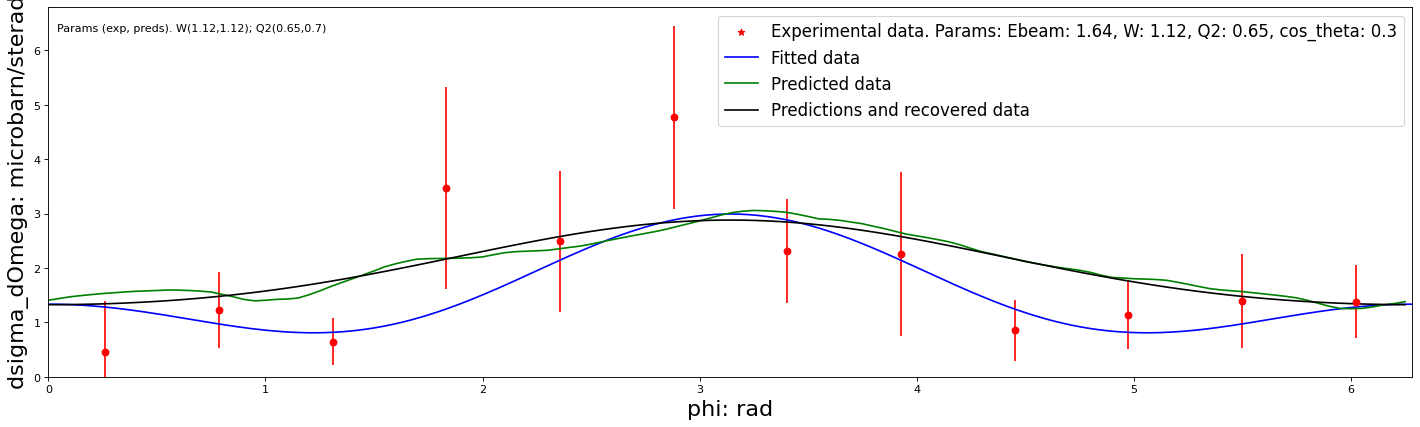

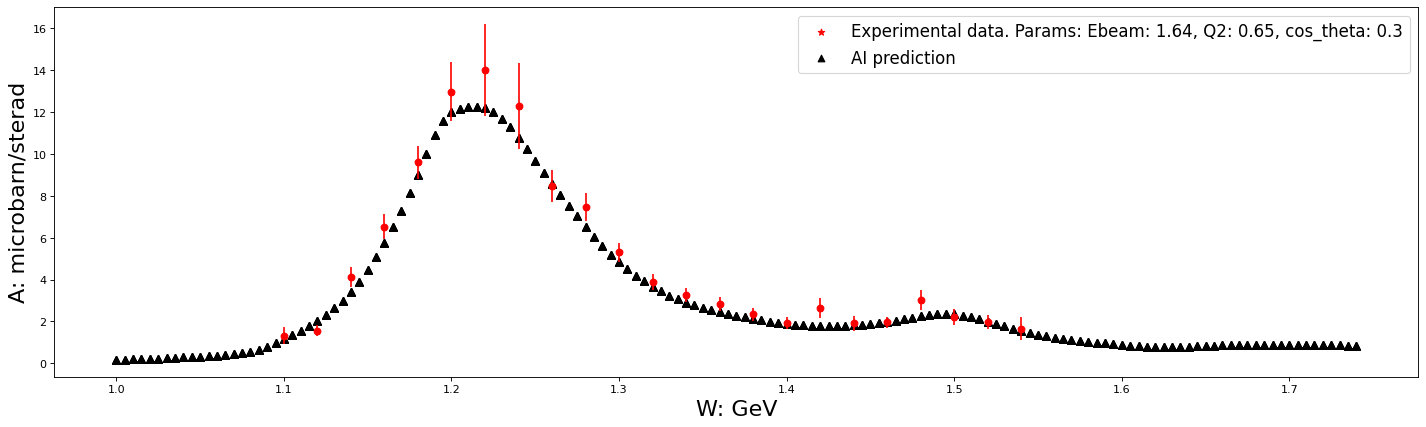

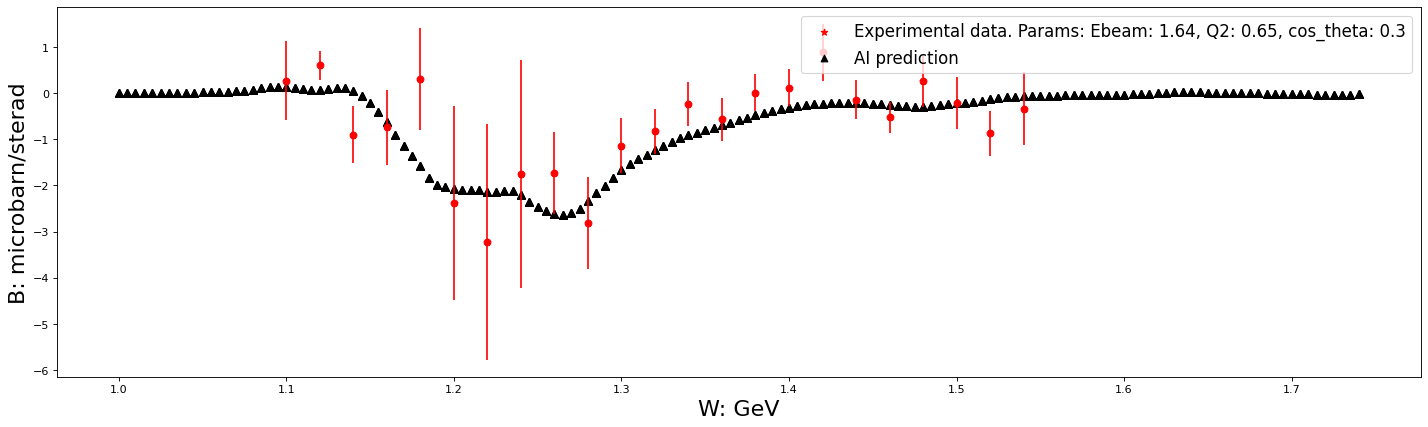

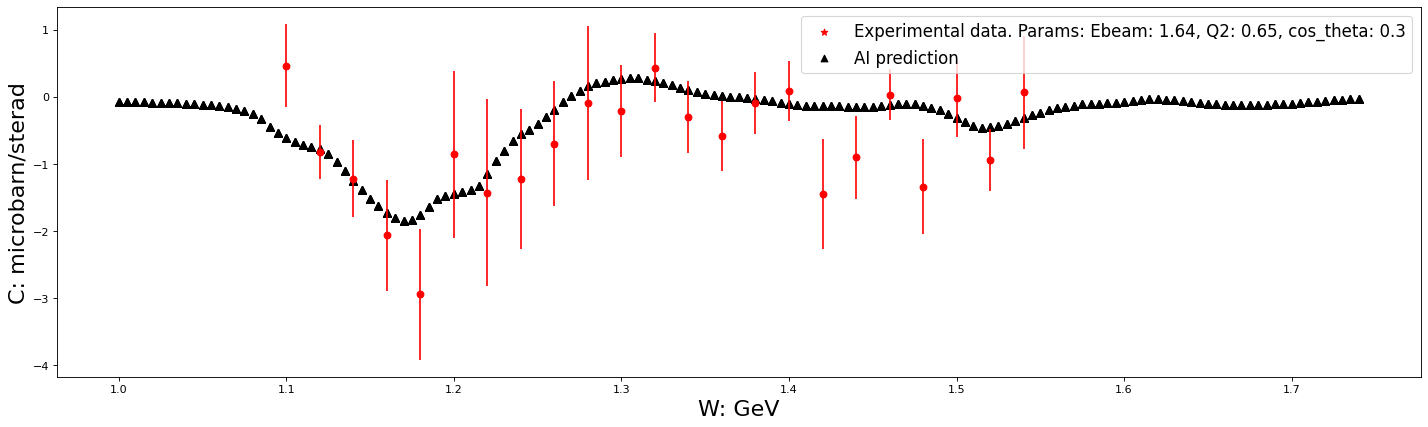

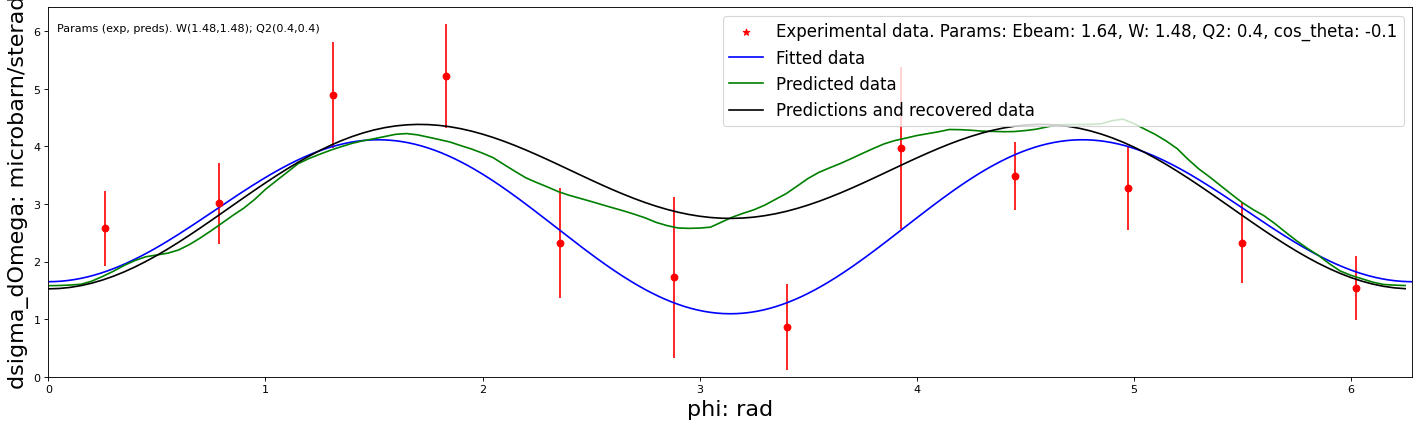

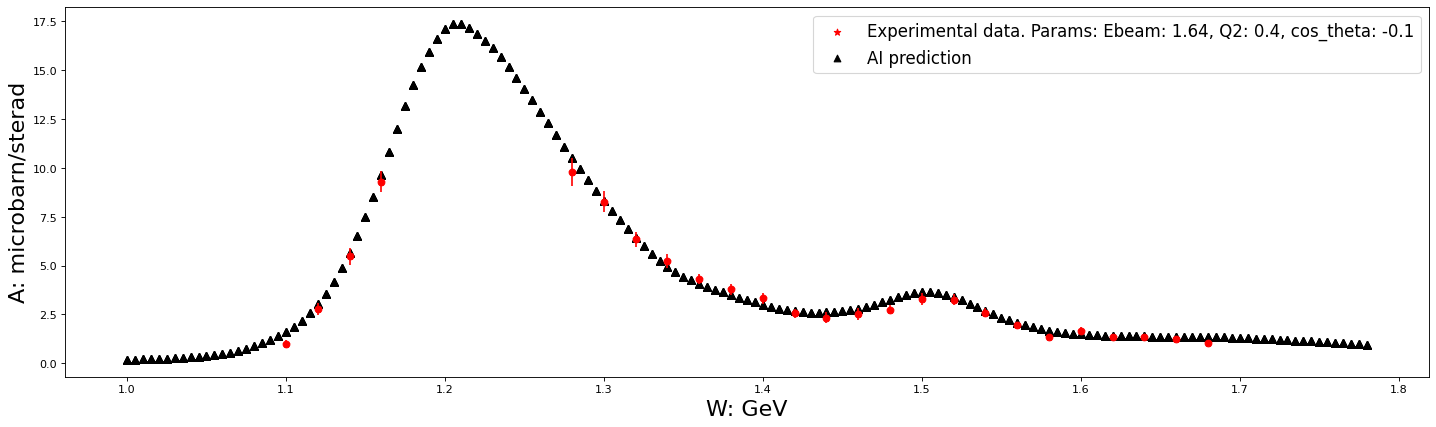

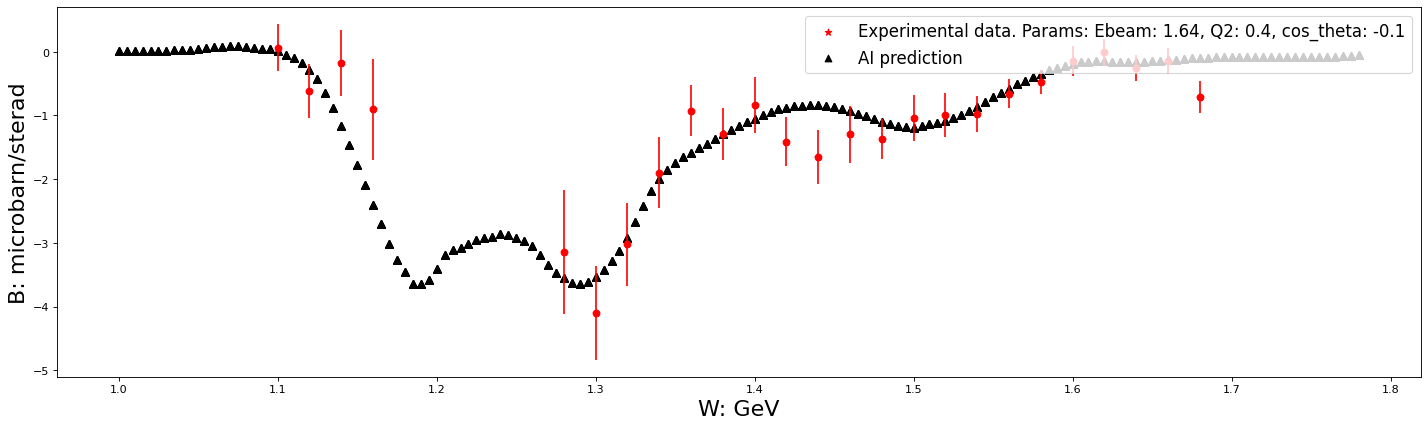

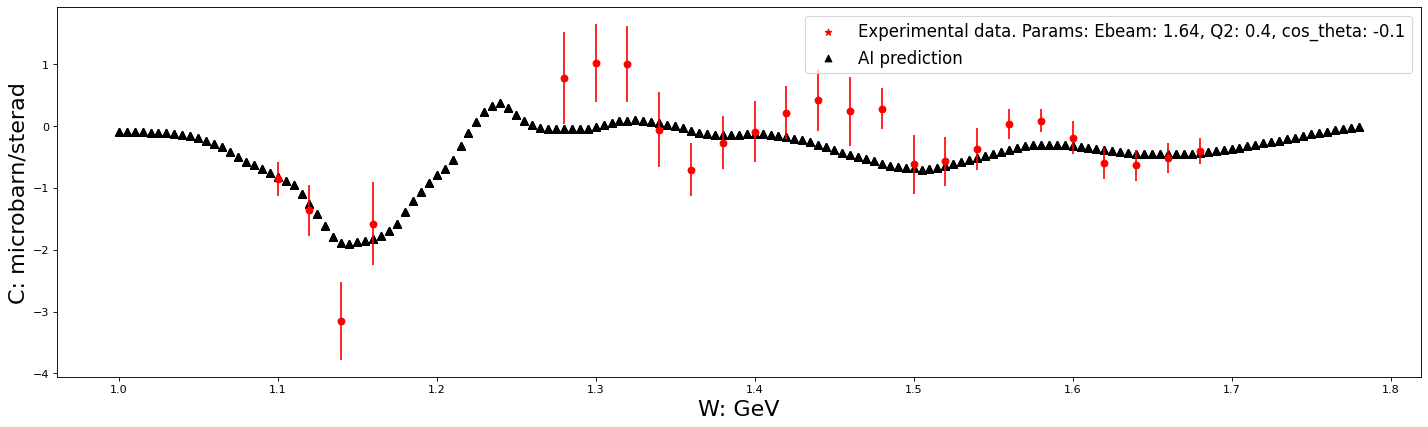

100%|██████████| 157/157 [00:08<00:00, 19.49it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
100%|██████████| 100/100 [21:08<00:00, 12.68s/it]


         Ebeam     W    Q2  cos_theta   phi   cos_phi   sin_phi  A  B  C  \
0         2.44  1.00  0.55       -1.0  0.00  1.000000  0.000000  0  0  0   
1         2.44  1.00  0.55       -1.0  0.05  0.998750  0.049979  0  0  0   
2         2.44  1.00  0.55       -1.0  0.10  0.995004  0.099833  0  0  0   
3         2.44  1.00  0.55       -1.0  0.15  0.988771  0.149438  0  0  0   
4         2.44  1.00  0.55       -1.0  0.20  0.980067  0.198669  0  0  0   
...        ...   ...   ...        ...   ...       ...       ... .. .. ..   
6231325   2.44  1.78  1.95        1.0  6.05  0.972935 -0.231078  0  0  0   
6231326   2.44  1.78  1.95        1.0  6.10  0.983268 -0.182163  0  0  0   
6231327   2.44  1.78  1.95        1.0  6.15  0.991144 -0.132792  0  0  0   
6231328   2.44  1.78  1.95        1.0  6.20  0.996542 -0.083089  0  0  0   
6231329   2.44  1.78  1.95        1.0  6.25  0.999449 -0.033179  0  0  0   

         dsigma_dOmega_predicted  
0                       0.011397  
1                

  0%|          | 0/49455 [00:00<?, ?it/s]<ipython-input-15-293442891514>:103: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.034457175484226506' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'A'] = A
<ipython-input-15-293442891514>:104: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.0010107443253643184' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'B'] = B
<ipython-input-15-293442891514>:105: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.022840817068937886' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[ph

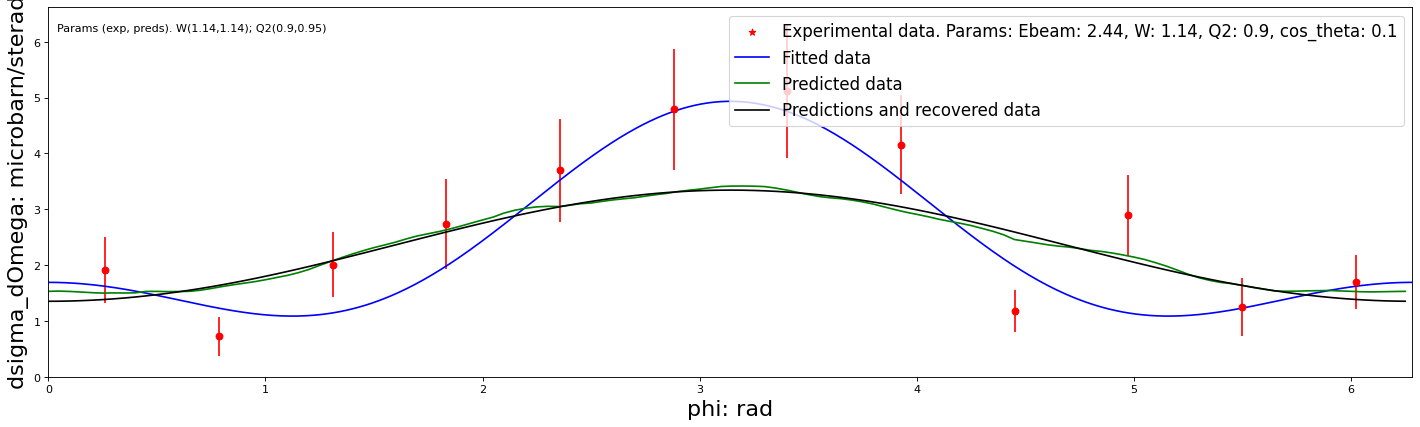

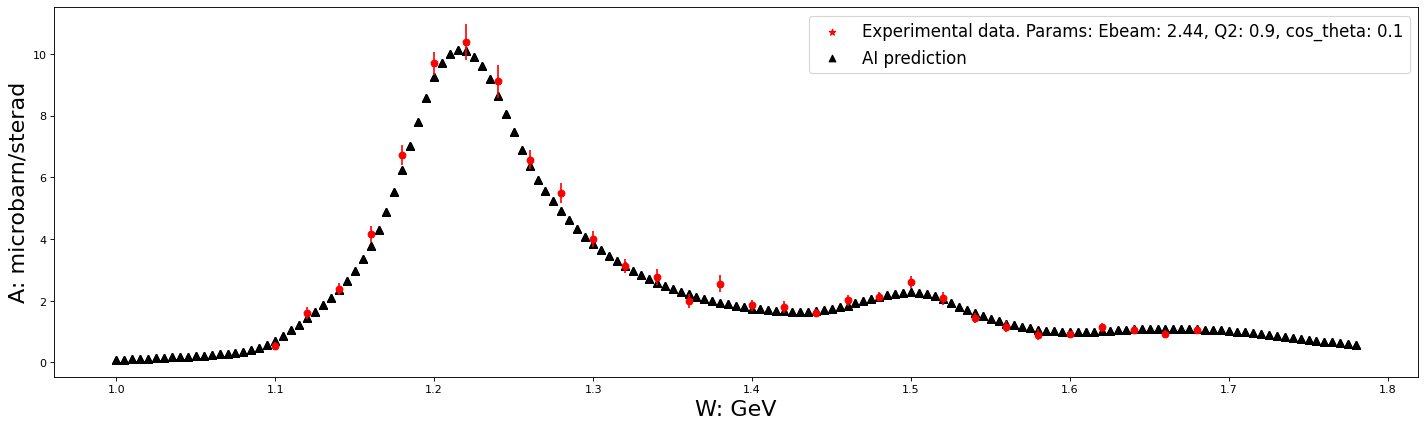

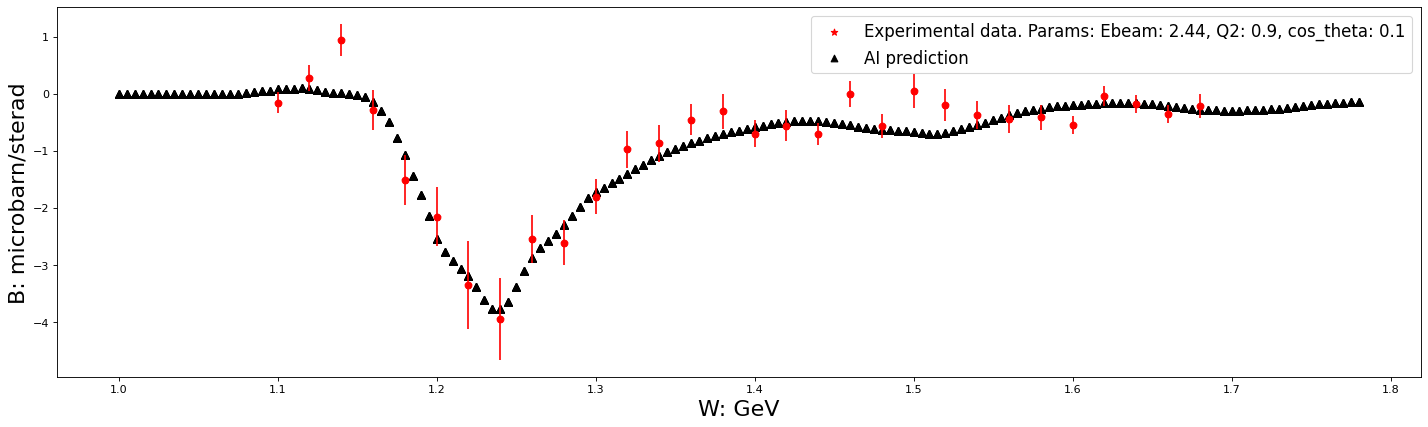

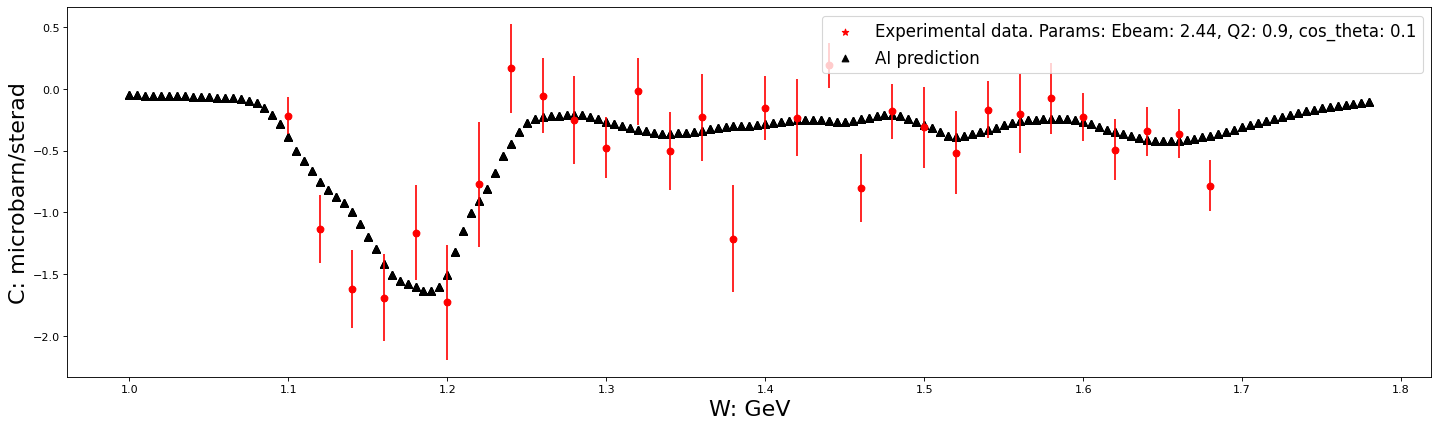

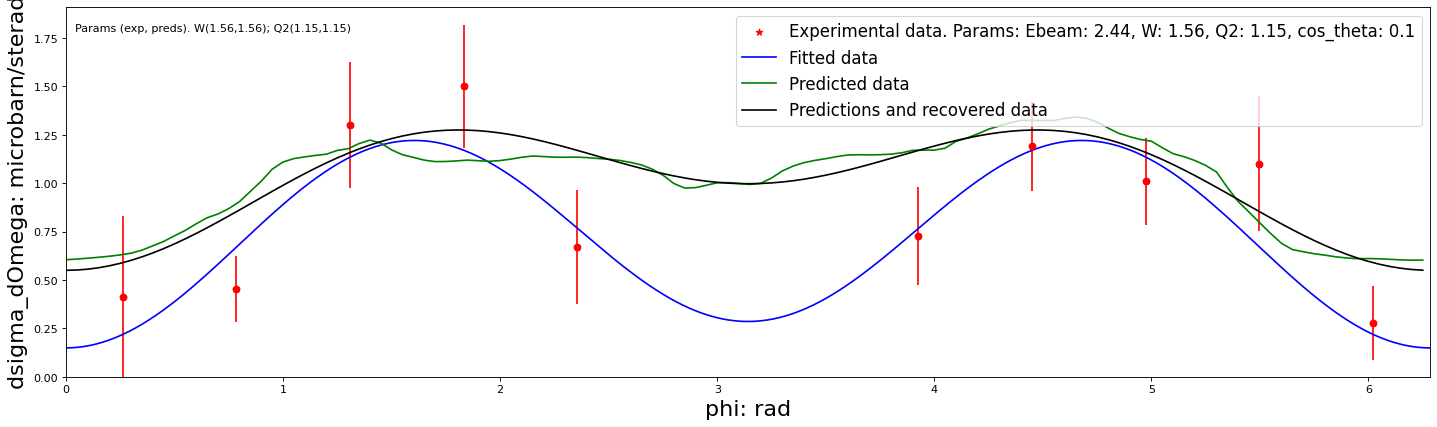

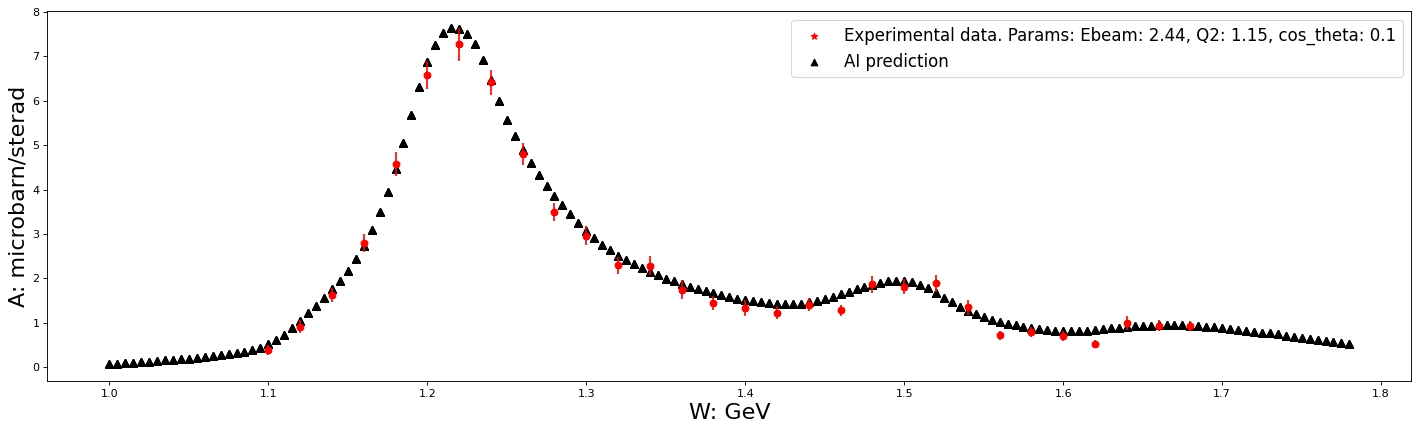

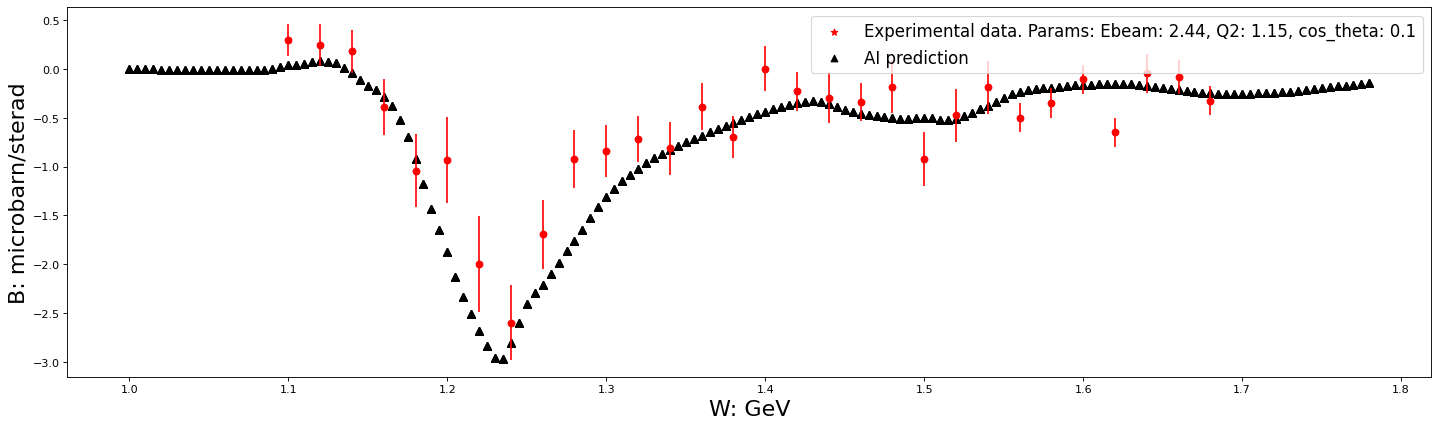

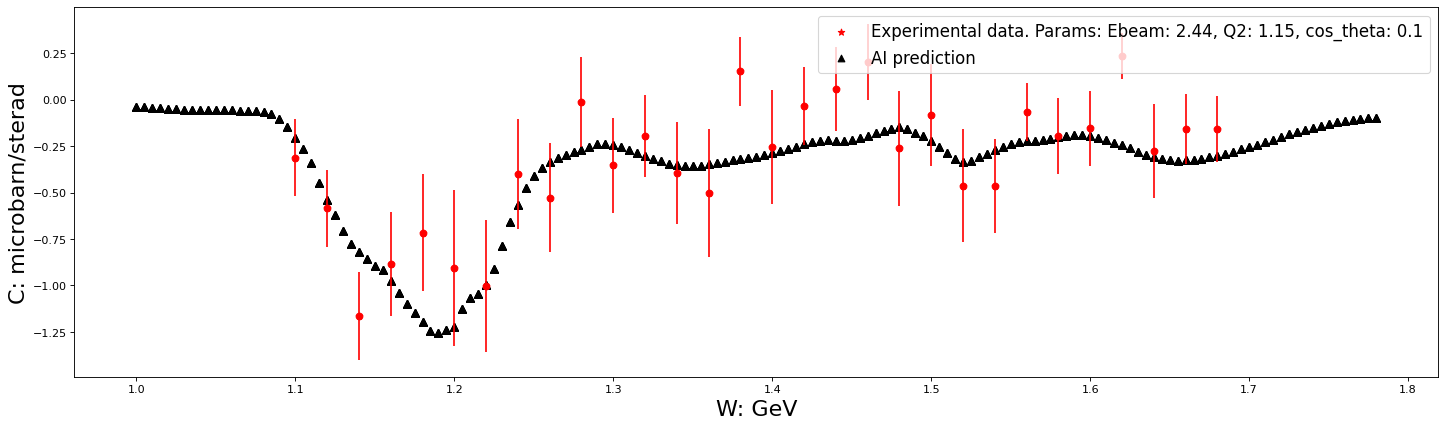

100%|██████████| 97/97 [00:10<00:00,  9.07it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
100%|██████████| 100/100 [29:06<00:00, 17.47s/it]


         Ebeam     W   Q2  cos_theta   phi   cos_phi   sin_phi  A  B  C  \
0         5.75  1.01  2.9       -1.0  0.00  1.000000  0.000000  0  0  0   
1         5.75  1.01  2.9       -1.0  0.05  0.998750  0.049979  0  0  0   
2         5.75  1.01  2.9       -1.0  0.10  0.995004  0.099833  0  0  0   
3         5.75  1.01  2.9       -1.0  0.15  0.988771  0.149438  0  0  0   
4         5.75  1.01  2.9       -1.0  0.20  0.980067  0.198669  0  0  0   
...        ...   ...  ...        ...   ...       ...       ... .. .. ..   
8469841   5.75  1.49  6.1        1.0  6.05  0.972935 -0.231078  0  0  0   
8469842   5.75  1.49  6.1        1.0  6.10  0.983268 -0.182163  0  0  0   
8469843   5.75  1.49  6.1        1.0  6.15  0.991144 -0.132792  0  0  0   
8469844   5.75  1.49  6.1        1.0  6.20  0.996542 -0.083089  0  0  0   
8469845   5.75  1.49  6.1        1.0  6.25  0.999449 -0.033179  0  0  0   

         dsigma_dOmega_predicted  
0                       0.054180  
1                       0.055

  0%|          | 0/67221 [00:00<?, ?it/s]<ipython-input-15-293442891514>:103: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.052787377875724344' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'A'] = A
<ipython-input-15-293442891514>:104: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.005763666424527936' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'B'] = B
<ipython-input-15-293442891514>:105: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.00692537620495091' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_

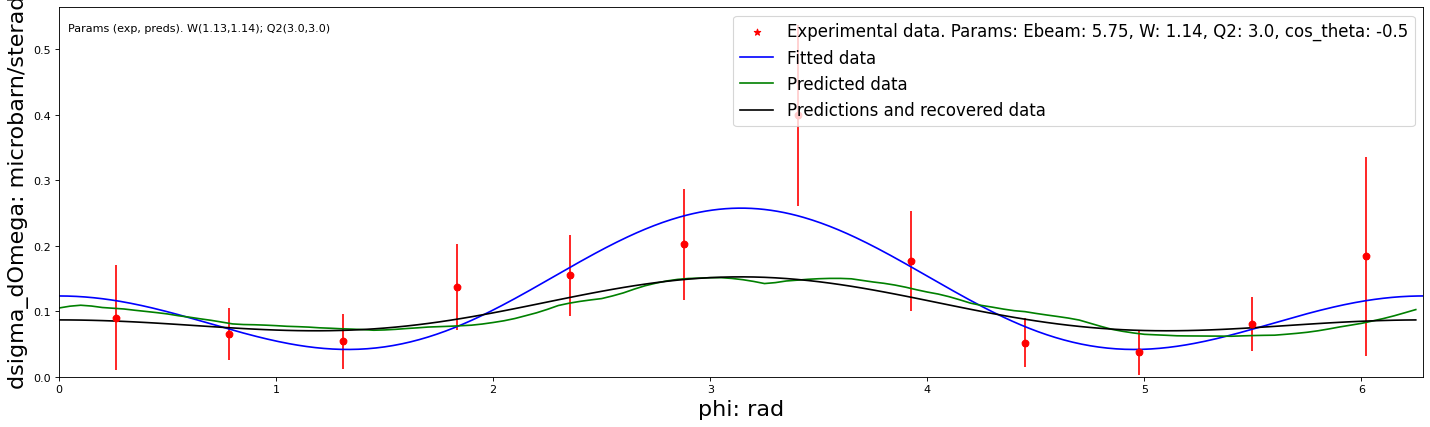

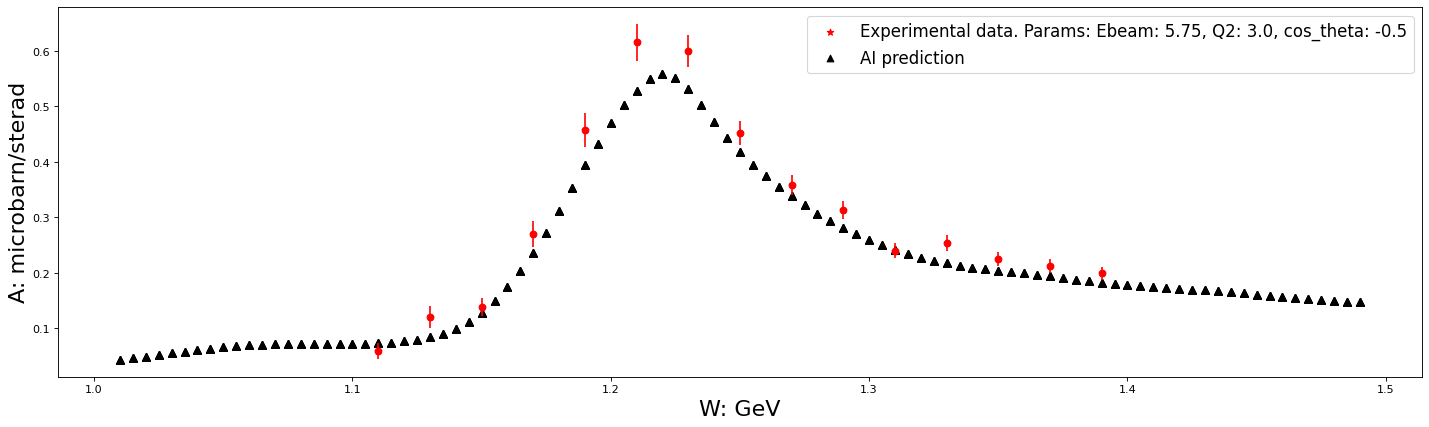

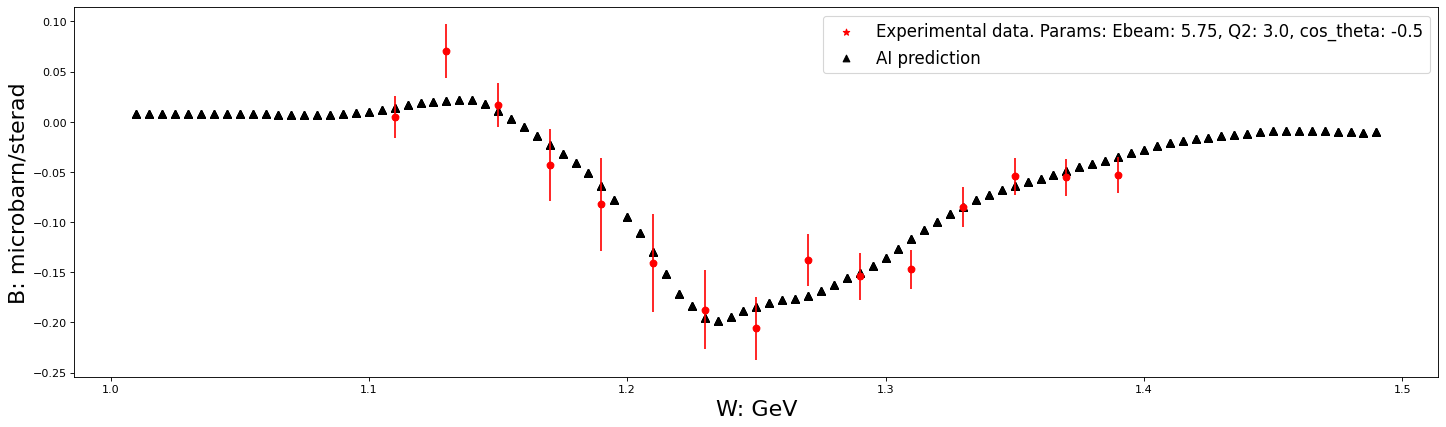

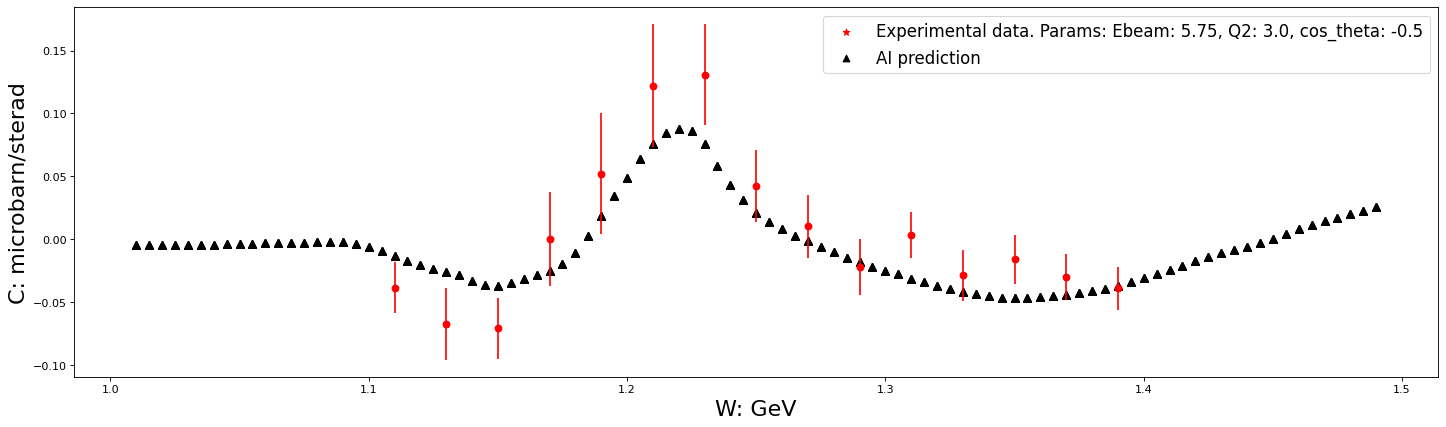

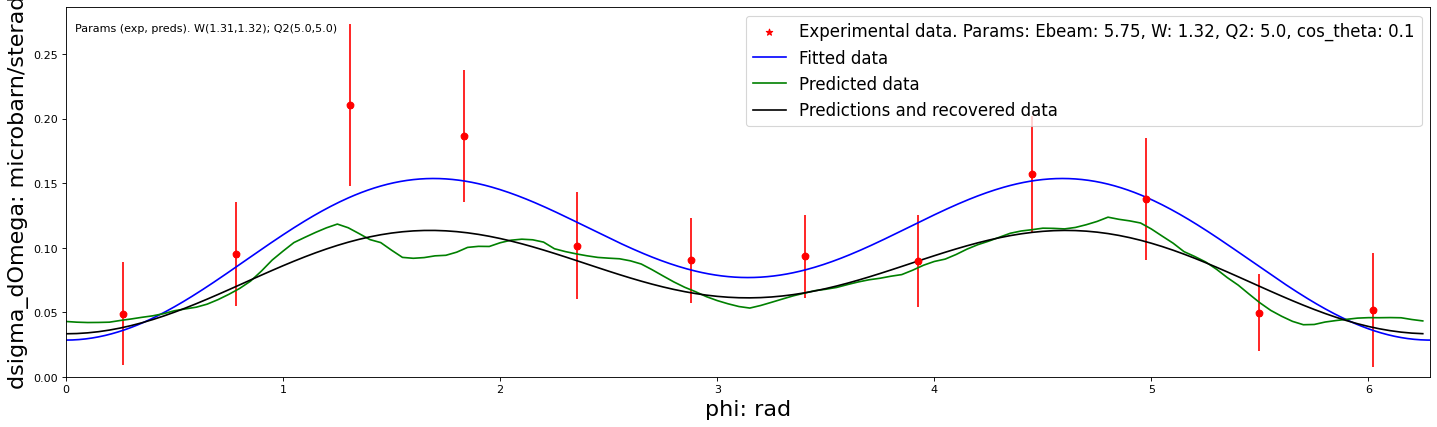

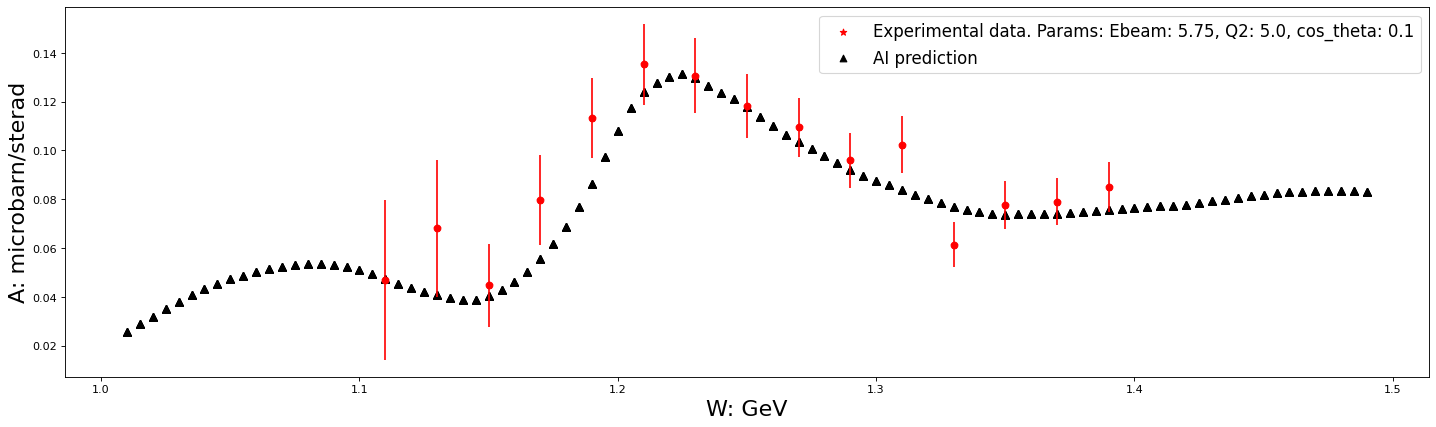

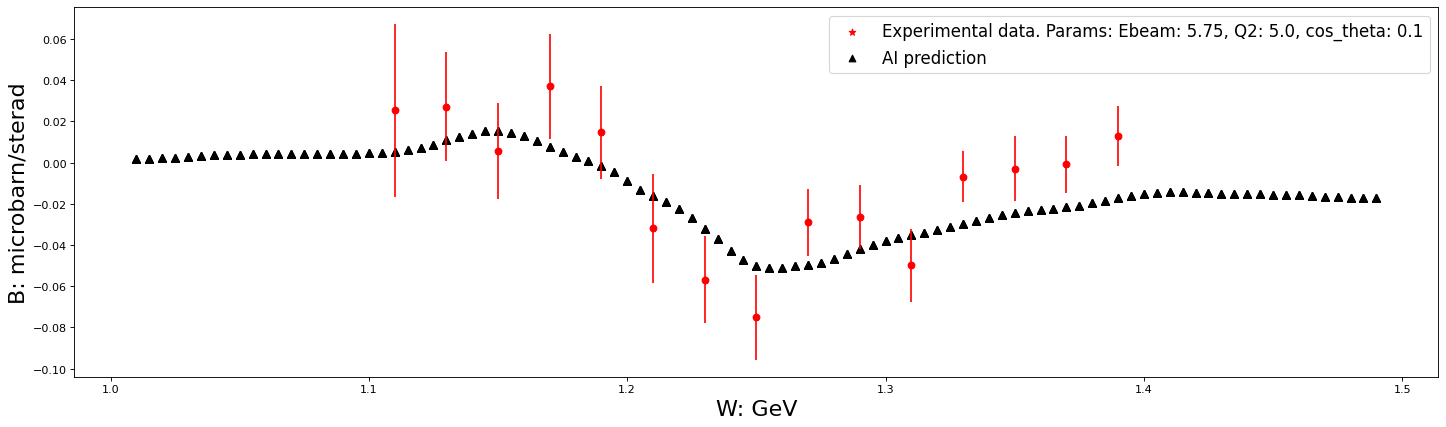

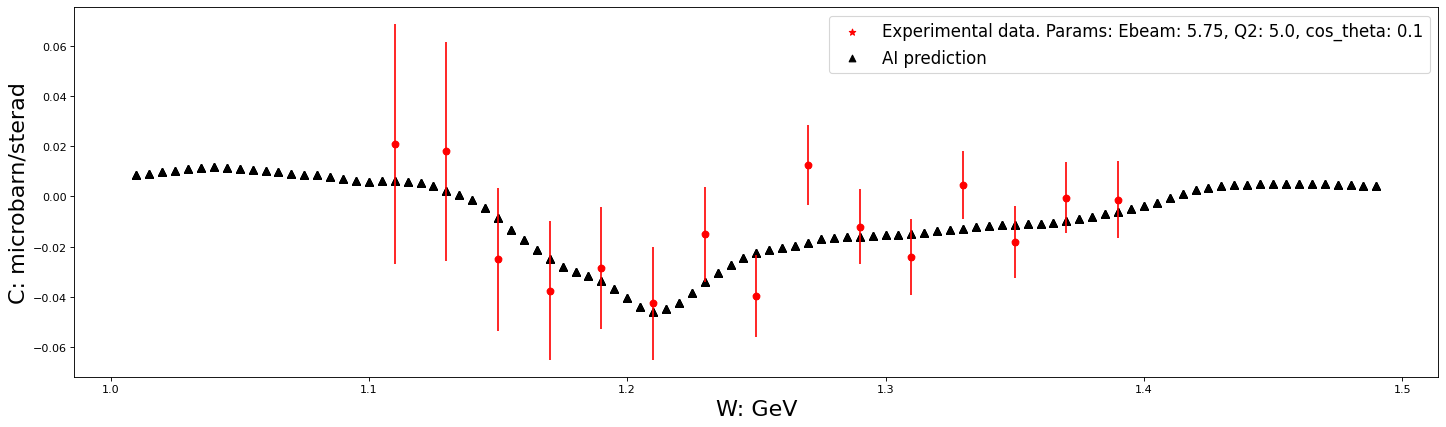

100%|██████████| 177/177 [00:03<00:00, 45.60it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
100%|██████████| 100/100 [14:03<00:00,  8.44s/it]


         Ebeam      W    Q2  cos_theta   phi   cos_phi   sin_phi  A  B  C  \
0         2.04  1.012  0.35       -1.0  0.00  1.000000  0.000000  0  0  0   
1         2.04  1.012  0.35       -1.0  0.05  0.998750  0.049979  0  0  0   
2         2.04  1.012  0.35       -1.0  0.10  0.995004  0.099833  0  0  0   
3         2.04  1.012  0.35       -1.0  0.15  0.988771  0.149438  0  0  0   
4         2.04  1.012  0.35       -1.0  0.20  0.980067  0.198669  0  0  0   
...        ...    ...   ...        ...   ...       ...       ... .. .. ..   
4215073   2.04  1.892  1.15        1.0  6.05  0.972935 -0.231078  0  0  0   
4215074   2.04  1.892  1.15        1.0  6.10  0.983268 -0.182163  0  0  0   
4215075   2.04  1.892  1.15        1.0  6.15  0.991144 -0.132792  0  0  0   
4215076   2.04  1.892  1.15        1.0  6.20  0.996542 -0.083089  0  0  0   
4215077   2.04  1.892  1.15        1.0  6.25  0.999449 -0.033179  0  0  0   

         dsigma_dOmega_predicted  
0                       0.080276  
1    

  0%|          | 0/33453 [00:00<?, ?it/s]<ipython-input-15-293442891514>:103: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.08520284380549172' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'A'] = A
<ipython-input-15-293442891514>:104: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.0006793400929427209' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi_min_index[i]:phi_max_index[i], 'B'] = B
<ipython-input-15-293442891514>:105: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.012687350266544682' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_grid.loc[phi

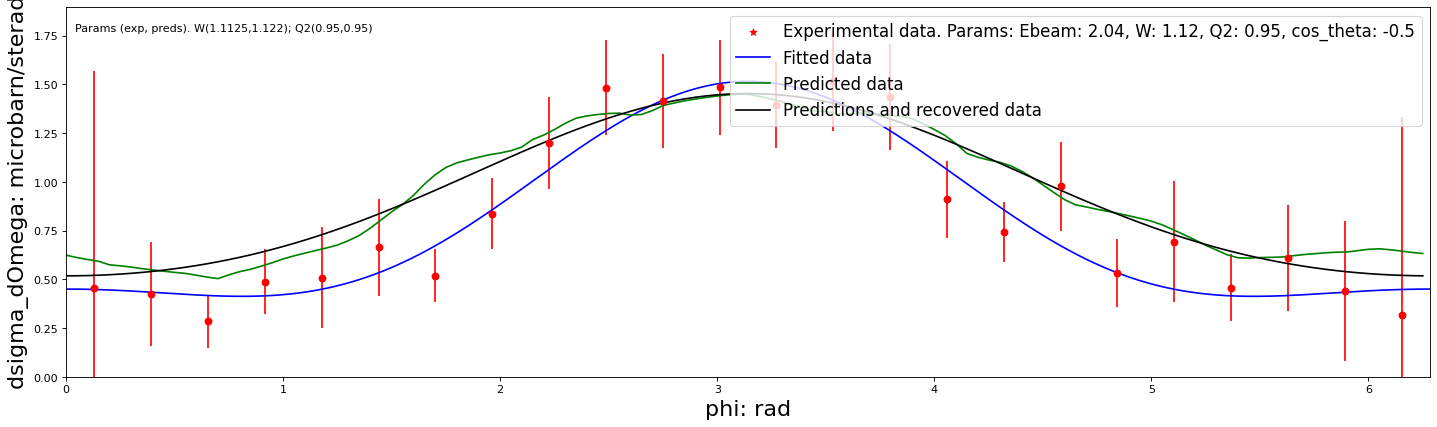

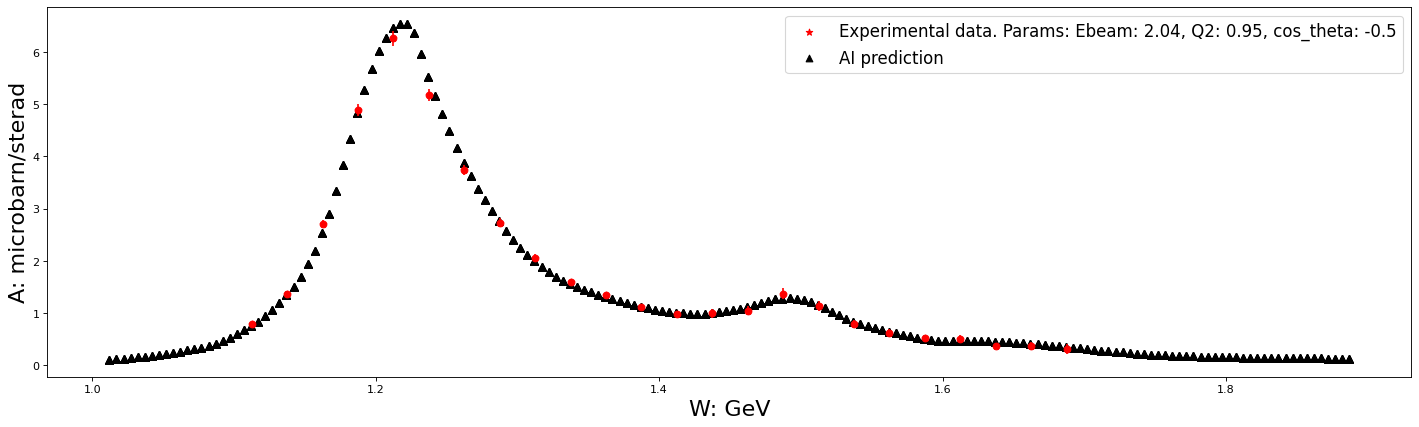

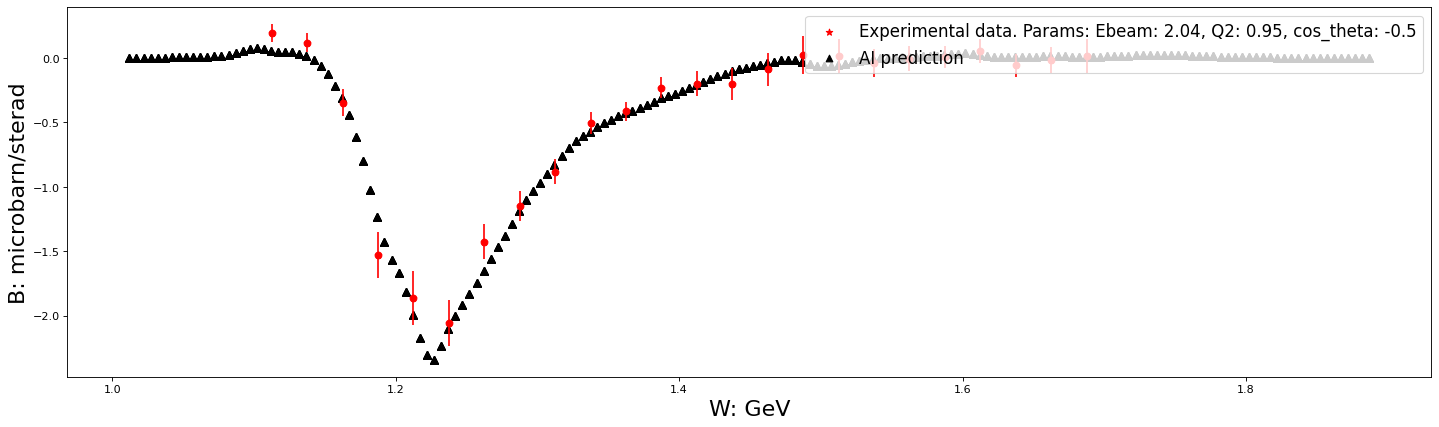

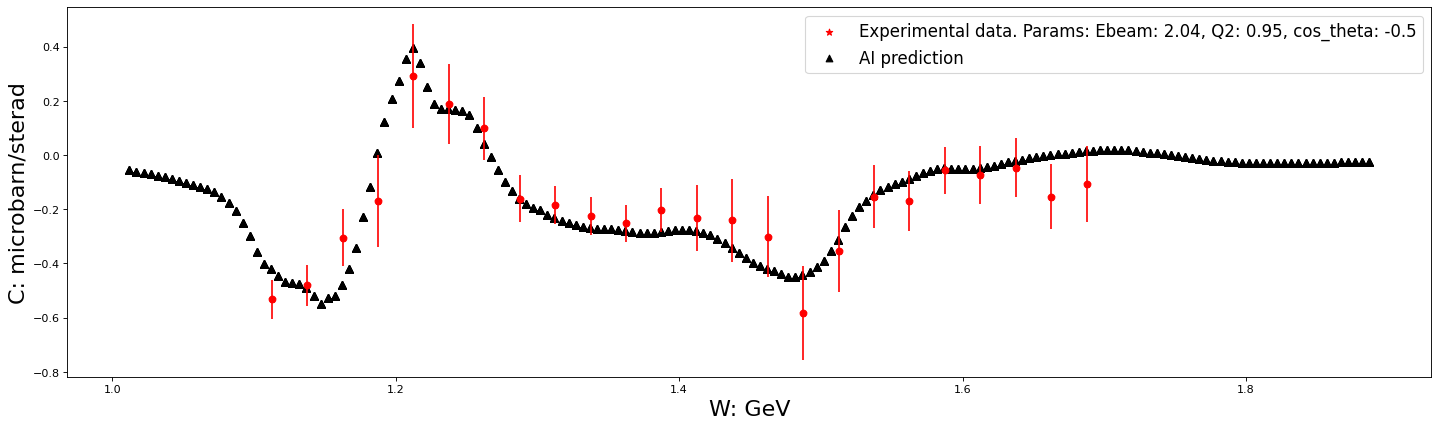

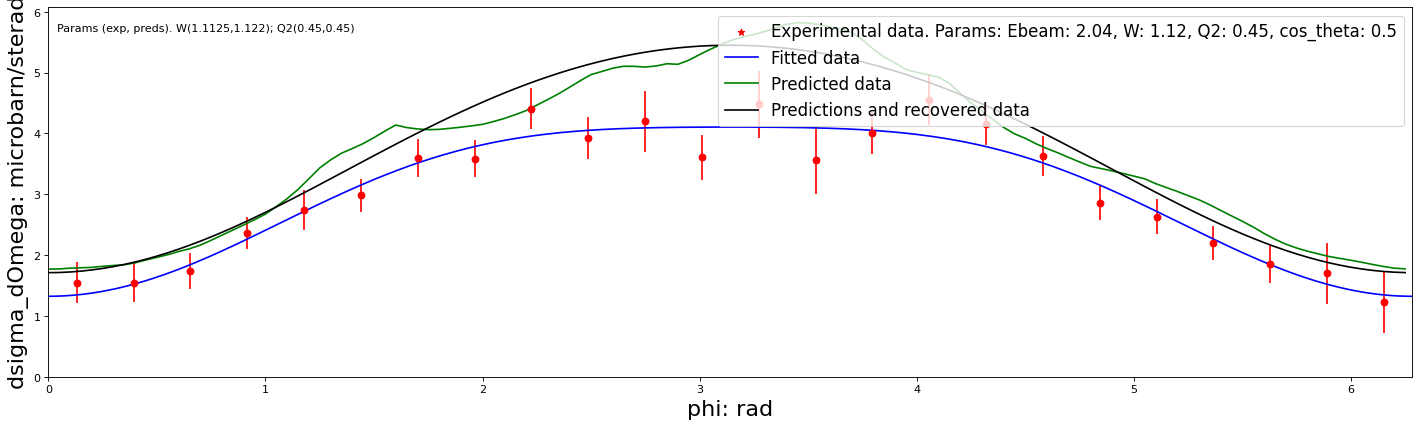

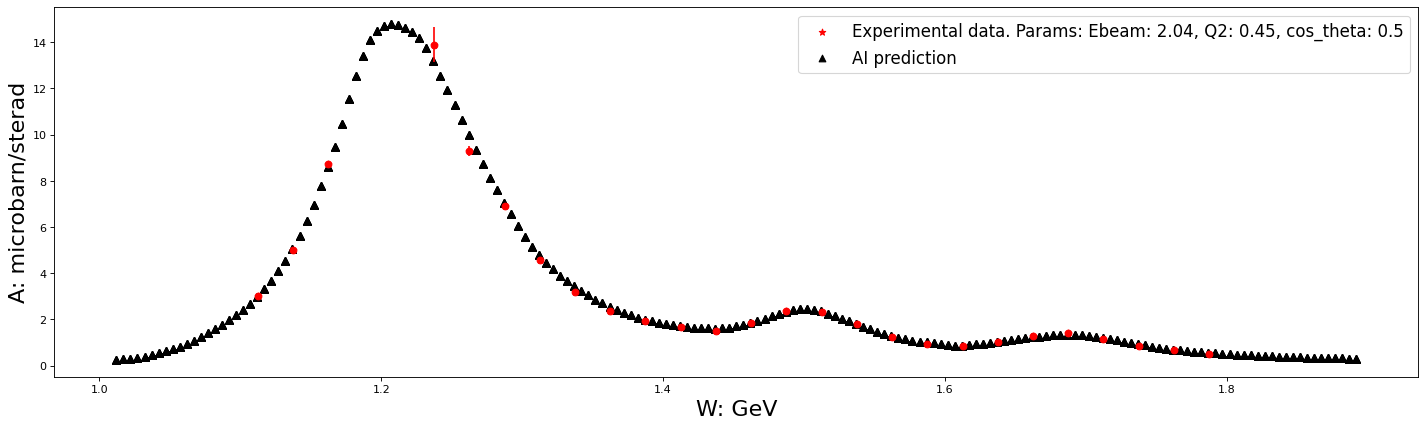

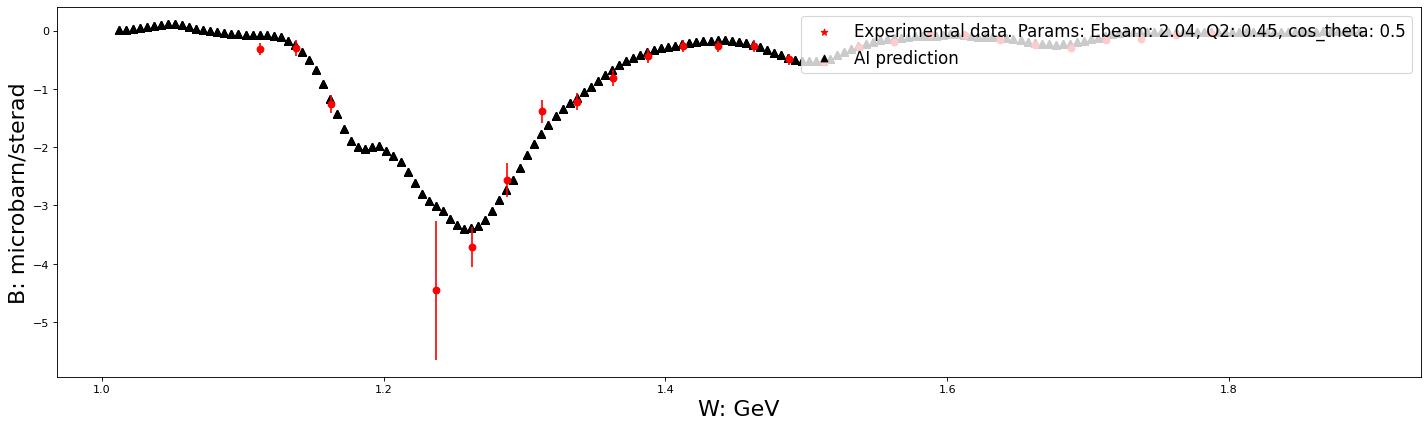

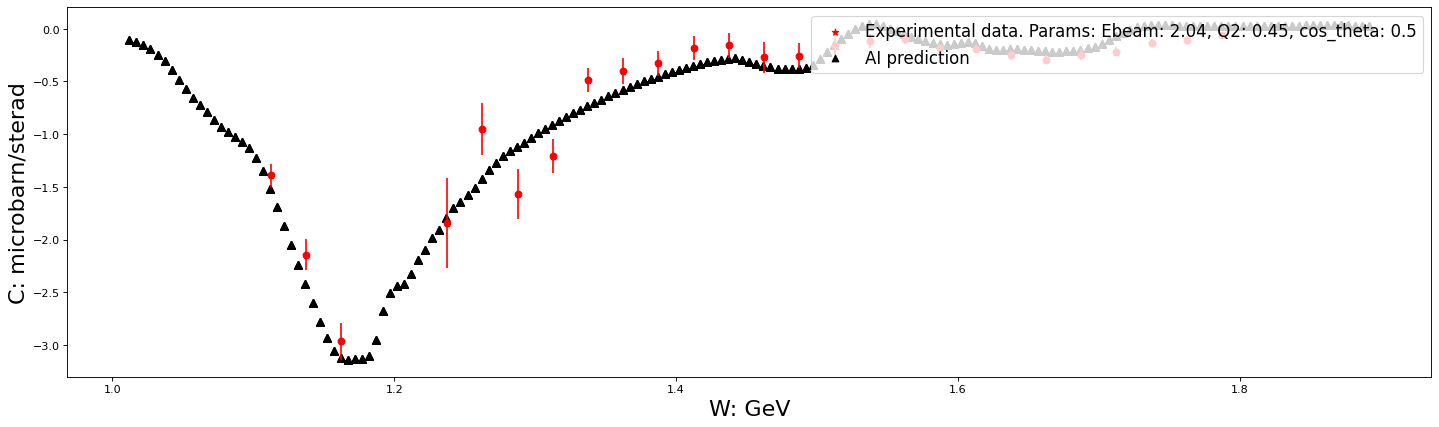

In [ ]:
def plot_cross_section_and_sf(Ebeam, W, Q2, cos_theta, df_grid, df_sf):
    plot_joint_cross_sections(df, Ebeam, W, Q2, cos_theta, df_grid)
    plot_joint_sf(df_sf, Ebeam, Q2, cos_theta, df_grid, func='A', func_error='A_error')
    plot_joint_sf(df_sf, Ebeam, Q2, cos_theta, df_grid, func='B', func_error='B_error')
    plot_joint_sf(df_sf, Ebeam, Q2, cos_theta, df_grid, func='C', func_error='C_error')
    return None

for Ebeam in [1.64, 2.44, 5.75, 2.04]:
    os.makedirs(f"/content/NN/E_beam={Ebeam}", exist_ok=True)
    df_grid = generate_grid_df(Ebeam)
    df_sf = generate_df_sf(Ebeam)

    W = list(df_for_plot[df_for_plot.Ebeam == Ebeam].W)[0]
    Q2 = list(df_for_plot[df_for_plot.Ebeam == Ebeam].Q2)[0]
    cos_theta = list(df_for_plot[df_for_plot.Ebeam == Ebeam].cos_theta)[0]
    plot_cross_section_and_sf(Ebeam, W, Q2, cos_theta, df_grid, df_sf)

    W = list(df_for_plot[df_for_plot.Ebeam == Ebeam].W)[1]
    Q2 = list(df_for_plot[df_for_plot.Ebeam == Ebeam].Q2)[1]
    cos_theta = list(df_for_plot[df_for_plot.Ebeam == Ebeam].cos_theta)[1]
    plot_cross_section_and_sf(Ebeam, W, Q2, cos_theta, df_grid, df_sf)

In [ ]:
# Log results to W&B Media

# for root, dirs, files in os.walk(os.path.abspath("/content/NN")):
#     for file in files:
#         path_to_img = os.path.join(root, file)
#         im = plt.imread(path_to_img)
#         wandb.log({"img": [wandb.Image(path_to_img)]})

wandb.log({"img": [wandb.Image('/content/NN/E_beam=1.64/E_beam=1.64_Q2=0.65_W=1.12_cos_theta=0.3.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=1.64/A_E_beam=1.64_Q2=0.65_cos_theta=0.3.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=1.64/B_E_beam=1.64_Q2=0.65_cos_theta=0.3.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=1.64/C_E_beam=1.64_Q2=0.65_cos_theta=0.3.png')]})

wandb.log({"img": [wandb.Image('/content/NN/E_beam=1.64/E_beam=1.64_Q2=0.4_W=1.48_cos_theta=-0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=1.64/A_E_beam=1.64_Q2=0.4_cos_theta=-0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=1.64/B_E_beam=1.64_Q2=0.4_cos_theta=-0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=1.64/C_E_beam=1.64_Q2=0.4_cos_theta=-0.1.png')]})




wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.04/E_beam=2.04_Q2=0.45_W=1.12_cos_theta=0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.04/A_E_beam=2.04_Q2=0.45_cos_theta=0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.04/B_E_beam=2.04_Q2=0.45_cos_theta=0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.04/C_E_beam=2.04_Q2=0.45_cos_theta=0.5.png')]})

wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.04/E_beam=2.04_Q2=0.95_W=1.12_cos_theta=-0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.04/A_E_beam=2.04_Q2=0.95_cos_theta=-0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.04/B_E_beam=2.04_Q2=0.95_cos_theta=-0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.04/C_E_beam=2.04_Q2=0.95_cos_theta=-0.5.png')]})




wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.44/E_beam=2.44_Q2=0.9_W=1.14_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.44/A_E_beam=2.44_Q2=0.9_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.44/C_E_beam=2.44_Q2=0.9_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.44/C_E_beam=2.44_Q2=0.9_cos_theta=0.1.png')]})

wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.44/E_beam=2.44_Q2=1.15_W=1.56_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.44/A_E_beam=2.44_Q2=1.15_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.44/B_E_beam=2.44_Q2=1.15_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=2.44/C_E_beam=2.44_Q2=1.15_cos_theta=0.1.png')]})




wandb.log({"img": [wandb.Image('/content/NN/E_beam=5.75/E_beam=5.75_Q2=3.0_W=1.14_cos_theta=-0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=5.75/A_E_beam=5.75_Q2=3.0_cos_theta=-0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=5.75/B_E_beam=5.75_Q2=3.0_cos_theta=-0.5.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=5.75/C_E_beam=5.75_Q2=3.0_cos_theta=-0.5.png')]})

wandb.log({"img": [wandb.Image('/content/NN/E_beam=5.75/E_beam=5.75_Q2=5.0_W=1.32_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=5.75/A_E_beam=5.75_Q2=5.0_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=5.75/B_E_beam=5.75_Q2=5.0_cos_theta=0.1.png')]})
wandb.log({"img": [wandb.Image('/content/NN/E_beam=5.75/C_E_beam=5.75_Q2=5.0_cos_theta=0.1.png')]})

2024-12-31 20:46:56,284 : DEBUG : STREAM b'IHDR' 16 13
2024-12-31 20:46:56,286 : DEBUG : STREAM b'tEXt' 41 57
2024-12-31 20:46:56,290 : DEBUG : STREAM b'pHYs' 110 9
2024-12-31 20:46:56,292 : DEBUG : STREAM b'IDAT' 131 65536
2024-12-31 20:46:56,316 : DEBUG : Starting new HTTPS connection (1): api.wandb.ai:443
2024-12-31 20:46:56,378 : DEBUG : https://api.wandb.ai:443 "POST /graphql HTTP/11" 200 None
2024-12-31 20:46:56,443 : DEBUG : https://api.wandb.ai:443 "POST /graphql HTTP/11" 200 None
2024-12-31 20:46:56,450 : DEBUG : STREAM b'IHDR' 16 13
2024-12-31 20:46:56,453 : DEBUG : STREAM b'tEXt' 41 57
2024-12-31 20:46:56,455 : DEBUG : STREAM b'pHYs' 110 9
2024-12-31 20:46:56,460 : DEBUG : STREAM b'IDAT' 131 65536
2024-12-31 20:46:56,480 : DEBUG : STREAM b'IHDR' 16 13
2024-12-31 20:46:56,483 : DEBUG : STREAM b'tEXt' 41 57
2024-12-31 20:46:56,485 : DEBUG : STREAM b'pHYs' 110 9
2024-12-31 20:46:56,492 : DEBUG : STREAM b'IDAT' 131 37586
2024-12-31 20:46:56,510 : DEBUG : STREAM b'IHDR' 16 13
202

In [ ]:
# Log results to W&B Artifacts

wandb_table = wandb.Table(columns=["Ebeam", "cross section","A","B","C"])


for root, dirs, files in os.walk(os.path.abspath("/content/NN//E_beam=1.64")):
    wandb_table.add_data('E_beam=1.64', wandb.Image('/content/NN/E_beam=1.64/E_beam=1.64_Q2=0.65_W=1.12_cos_theta=0.3.png'),
                         wandb.Image('/content/NN/E_beam=1.64/A_E_beam=1.64_Q2=0.65_cos_theta=0.3.png'),
                         wandb.Image('/content/NN/E_beam=1.64/B_E_beam=1.64_Q2=0.65_cos_theta=0.3.png'),
                         wandb.Image('/content/NN/E_beam=1.64/C_E_beam=1.64_Q2=0.65_cos_theta=0.3.png'))

    wandb_table.add_data('E_beam=1.64', wandb.Image('/content/NN/E_beam=1.64/E_beam=1.64_Q2=0.4_W=1.48_cos_theta=-0.1.png'),
                         wandb.Image('/content/NN/E_beam=1.64/A_E_beam=1.64_Q2=0.4_cos_theta=-0.1.png'),
                         wandb.Image('/content/NN/E_beam=1.64/B_E_beam=1.64_Q2=0.4_cos_theta=-0.1.png'),
                         wandb.Image('/content/NN/E_beam=1.64/C_E_beam=1.64_Q2=0.4_cos_theta=-0.1.png'))



for root, dirs, files in os.walk(os.path.abspath("/content/NN/E_beam=2.04")):
    wandb_table.add_data('E_beam=2.04', wandb.Image('/content/NN/E_beam=2.04/E_beam=2.04_Q2=0.45_W=1.12_cos_theta=0.5.png'),
                         wandb.Image('/content/NN/E_beam=2.04/A_E_beam=2.04_Q2=0.45_cos_theta=0.5.png'),
                         wandb.Image('/content/NN/E_beam=2.04/B_E_beam=2.04_Q2=0.45_cos_theta=0.5.png'),
                         wandb.Image('/content/NN/E_beam=2.04/C_E_beam=2.04_Q2=0.45_cos_theta=0.5.png'))

    wandb_table.add_data('E_beam=2.04', wandb.Image('/content/NN/E_beam=2.04/E_beam=2.04_Q2=0.95_W=1.12_cos_theta=-0.5.png'),
                         wandb.Image('/content/NN/E_beam=2.04/A_E_beam=2.04_Q2=0.95_cos_theta=-0.5.png'),
                         wandb.Image('/content/NN/E_beam=2.04/B_E_beam=2.04_Q2=0.95_cos_theta=-0.5.png'),
                         wandb.Image('/content/NN/E_beam=2.04/C_E_beam=2.04_Q2=0.95_cos_theta=-0.5.png'))



for root, dirs, files in os.walk(os.path.abspath("/content/NN/E_beam=2.44")):
    wandb_table.add_data('E_beam=2.44', wandb.Image('/content/NN/E_beam=2.44/E_beam=2.44_Q2=0.9_W=1.14_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=2.44/A_E_beam=2.44_Q2=0.9_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=2.44/C_E_beam=2.44_Q2=0.9_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=2.44/C_E_beam=2.44_Q2=0.9_cos_theta=0.1.png'))

    wandb_table.add_data('E_beam=2.44', wandb.Image('/content/NN/E_beam=2.44/E_beam=2.44_Q2=1.15_W=1.56_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=2.44/A_E_beam=2.44_Q2=1.15_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=2.44/B_E_beam=2.44_Q2=1.15_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=2.44/C_E_beam=2.44_Q2=1.15_cos_theta=0.1.png'))



for root, dirs, files in os.walk(os.path.abspath("/content/NN/E_beam=5.75")):
    wandb_table.add_data('E_beam=5.75', wandb.Image('/content/NN/E_beam=5.75/E_beam=5.75_Q2=3.0_W=1.14_cos_theta=-0.5.png'),
                         wandb.Image('/content/NN/E_beam=5.75/A_E_beam=5.75_Q2=3.0_cos_theta=-0.5.png'),
                         wandb.Image('/content/NN/E_beam=5.75/B_E_beam=5.75_Q2=3.0_cos_theta=-0.5.png'),
                         wandb.Image('/content/NN/E_beam=5.75/C_E_beam=5.75_Q2=3.0_cos_theta=-0.5.png'))

    wandb_table.add_data('E_beam=5.75', wandb.Image('/content/NN/E_beam=5.75/E_beam=5.75_Q2=5.0_W=1.32_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=5.75/A_E_beam=5.75_Q2=5.0_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=5.75/B_E_beam=5.75_Q2=5.0_cos_theta=0.1.png'),
                         wandb.Image('/content/NN/E_beam=5.75/C_E_beam=5.75_Q2=5.0_cos_theta=0.1.png'))



# Create a wandb Artifact
artifact = wandb.Artifact(name="plots", type="data")
# Add the table to the artifact
#artifact.add(wandb.Image(path_to_img), "plots_E_beam={Ebeam}")
artifact.add(wandb_table, f"plots")
# Log the artifact
wandb.log_artifact(artifact)

2024-12-31 20:46:59,084 : DEBUG : STREAM b'IHDR' 16 13
2024-12-31 20:46:59,091 : DEBUG : STREAM b'tEXt' 41 57
2024-12-31 20:46:59,094 : DEBUG : STREAM b'pHYs' 110 9
2024-12-31 20:46:59,098 : DEBUG : STREAM b'IDAT' 131 65536
2024-12-31 20:46:59,123 : DEBUG : STREAM b'IHDR' 16 13
2024-12-31 20:46:59,128 : DEBUG : STREAM b'tEXt' 41 57
2024-12-31 20:46:59,132 : DEBUG : STREAM b'pHYs' 110 9
2024-12-31 20:46:59,135 : DEBUG : STREAM b'IDAT' 131 37586
2024-12-31 20:46:59,164 : DEBUG : STREAM b'IHDR' 16 13
2024-12-31 20:46:59,168 : DEBUG : STREAM b'tEXt' 41 57
2024-12-31 20:46:59,175 : DEBUG : STREAM b'pHYs' 110 9
2024-12-31 20:46:59,179 : DEBUG : STREAM b'IDAT' 131 36252
2024-12-31 20:46:59,204 : DEBUG : STREAM b'IHDR' 16 13
2024-12-31 20:46:59,207 : DEBUG : STREAM b'tEXt' 41 57
2024-12-31 20:46:59,210 : DEBUG : STREAM b'pHYs' 110 9
2024-12-31 20:46:59,214 : DEBUG : STREAM b'IDAT' 131 35907
2024-12-31 20:46:59,233 : DEBUG : STREAM b'IHDR' 16 13
2024-12-31 20:46:59,236 : DEBUG : STREAM b'tEXt' 

<Artifact plots>

In [ ]:
wandb.finish()

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
lr_scheduler_monitoring,█████████▄▄▄▄▄▄▄▄▄▄▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_mae,█▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_mse,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_r2,▁▇▇▇▇▇██████████████████████████████████
train_rmse,█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
val_loss,██▅▃▄▄▃▄▂▁▂▁▂▂▁▂▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mae,▇█▅▃▄▄▄▅▃▂▂▂▂▂▂▂▁▂▃▁▂▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mse,██▅▃▄▄▃▄▂▁▂▁▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


In [ ]:
# #for random choice cross sections and structure functions
# os.makedirs(f"/content/NN/cross_sections", exist_ok=True)
# os.makedirs(f"/content/NN/structure_functions", exist_ok=True)
# for Ebeam in [1.64, 2.44, 5.75, 2.04]:
#     df_grid = generate_grid_df(Ebeam)
#     df_sf = generate_df_sf(Ebeam)
#     step = 0
#     while step != 2:
#         picture_is_not_drawn = True
#         while picture_is_not_drawn:
#             Q2 = random.choice(df[df.Ebeam==Ebeam].Q2.unique())
#             W = random.choice(df[(df.Ebeam==Ebeam) & (df.Q2==Q2)].W.unique())
#             cos_theta = random.choice(df[(df.Ebeam==Ebeam) & (df.Q2==Q2) & (df.W==W)].cos_theta.unique())
#             try:
#                 plot_joint_cross_sections(df, Ebeam, W, Q2, cos_theta, df_grid)
#             except:
#                 print(Ebeam, W, Q2, cos_theta)
#             else:
#                 plot_joint_sf(df_sf, Ebeam, Q2, cos_theta, df_grid, func='A', func_error='A_error')
#                 plot_joint_sf(df_sf, Ebeam, Q2, cos_theta, df_grid, func='B', func_error='B_error')
#                 plot_joint_sf(df_sf, Ebeam, Q2, cos_theta, df_grid, func='C', func_error='C_error')
#                 step += 1
#                 picture_is_not_drawn = False